<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/12hours_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airqino table Data
Average data values (every 12 hours) of July, August, September, October and November to predict the last 36 days of the selected data

In [ ]:
import pandas as pd
import psycopg2
import pytz
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('12 hour', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-12-10 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
europe = pytz.timezone('Europe/Rome')
df.index = df.index.tz_localize(pytz.utc).tz_convert(europe)
#make the dates a string
df.reset_index(level=0, inplace=True)
for i in range(len(df)):
  df['Dates'][i]=df['Dates'][i].strftime('%Y-%m-%d %H')
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)
df=df.dropna()
display(df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 02,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481
2021-06-29 14,485.677582,1.229219,408.007557,44.385567,30.052645,6.357683,441.720403,251.073048,226.254408,389.267003
2021-06-30 02,403.322440,1.917211,408.718954,40.068039,25.106100,9.461874,562.250545,268.991285,223.769063,356.978214
2021-06-30 14,355.258373,1.700957,405.818182,40.966938,26.467464,9.514354,408.889952,194.583732,206.466507,352.296651
2021-07-01 02,374.174312,2.975535,420.651376,36.713639,21.714679,12.700306,658.027523,309.171254,226.581040,352.969419
...,...,...,...,...,...,...,...,...,...,...
2021-12-07 13,471.201699,31.405520,490.388535,16.172718,4.527176,44.700637,746.286624,205.861996,210.118896,366.076433
2021-12-08 01,562.745182,35.755889,501.655246,14.800535,2.230835,45.019272,981.447537,257.460385,224.274090,348.239829
2021-12-08 13,520.709130,65.781316,469.065817,18.256051,5.544798,99.751592,999.000000,253.044586,245.318471,343.836518


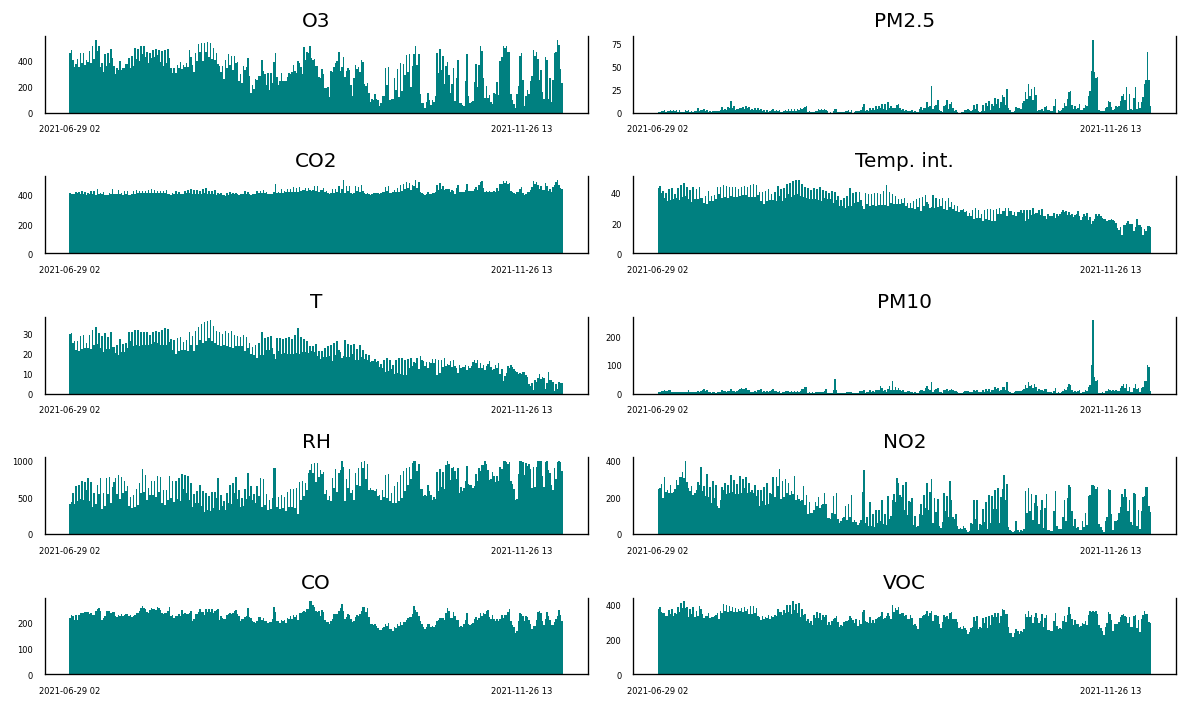

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
x_ticks = np.arange(0, len(df), 300)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.bar(data.index, data, color='teal', align='edge', width=1.0)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=5)
    ax.set_xticks(x_ticks)


plt.tight_layout();

# Wind data

Add the wind (mean value)

Int64Index([11896], dtype='int64')


,Wind
Date,
2021-06-29 02,0.683333
2021-06-29 14,1.91458
2021-06-30 02,2.09167
2021-06-30 14,2.0875
2021-07-01 02,1.18125
...,...
2021-12-07 13,0.904167
2021-12-08 01,0.810417
2021-12-08 13,0.958333


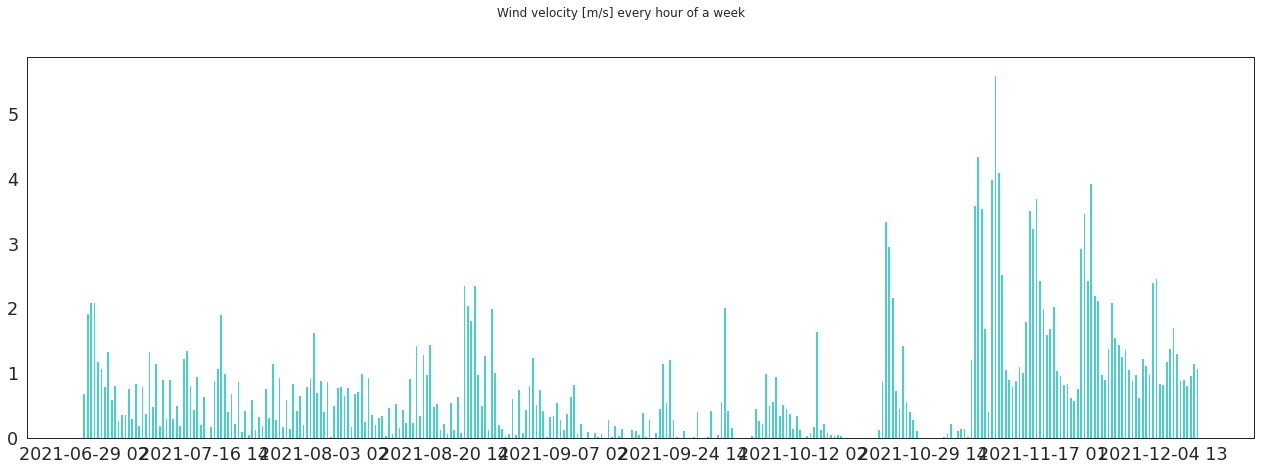

<Figure size 432x288 with 0 Axes>

In [ ]:
wind_temp = pd.read_csv('https://raw.githubusercontent.com/marcochisci/Anomaly_detection/main/anemo.csv')
wind_temp=wind_temp.set_index('Date')
wind_temp=wind_temp.loc['2021-06-29 02:00':'2021-12-10 01:00']
wind_temp.reset_index(level=0, inplace=True)
#duplicare i dati dell'ora '2021-10-31 00:00' per evitare problemi con fuso orario
index_change=wind_temp[wind_temp['Date']=='2021-10-31 00:00'].index
print(index_change)
line = pd.DataFrame({"Date": ['2021-10-31 00:00','2021-10-31 00:15', '2021-10-31 00:30', '2021-10-31 00:45'], " Velocità [m/s]": [0,0,0,0]})
wind_temp = pd.concat([wind_temp.iloc[:11896], line, wind_temp.iloc[11896:]]).reset_index(drop=True)
wind_temp=wind_temp.drop([' Potenza'], axis=1)
#ogni 12 ore fa la media, 48 valori (ogni 15 minuti 1 valore)
num_values=48
how_many=int(len(wind_temp)/num_values)
wind_df=pd.DataFrame(columns=wind_temp.columns)
for i in range(how_many):
  value=0
  for j in range(num_values):
    value=value+wind_temp[' Velocità [m/s]'][i*num_values+j]
  value=value/num_values
  wind_df.loc[i,:]=[wind_temp['Date'][i*num_values],value]
#cambia formato delle date
for i in range(len(wind_df)):
  wind_df['Date'][i]=datetime.datetime.strptime(wind_df['Date'][i], "%Y-%m-%d %H:%M").strftime('%Y-%m-%d %H')
wind_df=wind_df.set_index('Date')
wind_df= wind_df.rename(columns={' Velocità [m/s]': 'Wind'})
display(wind_df)

# Plot
data_wind=wind_df['Wind']
plt.figure(figsize=(22, 7))
plt.bar(wind_df.index, data_wind, color='mediumturquoise',align='edge', linewidth=1)
# Decorations
x_ticks = np.arange(0, len(wind_df), 35)
plt.xticks(x_ticks)
plt.suptitle('Wind velocity [m/s] every hour of a week')
plt.show()

plt.tight_layout();


Add the wind (median value)

Int64Index([11896], dtype='int64')


,Wind
Date,
2021-06-29 02,0.45
2021-06-29 14,2.1
2021-06-30 02,1.85
2021-06-30 14,1.85
2021-07-01 02,1
...,...
2021-12-07 13,0.8
2021-12-08 01,0.8
2021-12-08 13,0.85


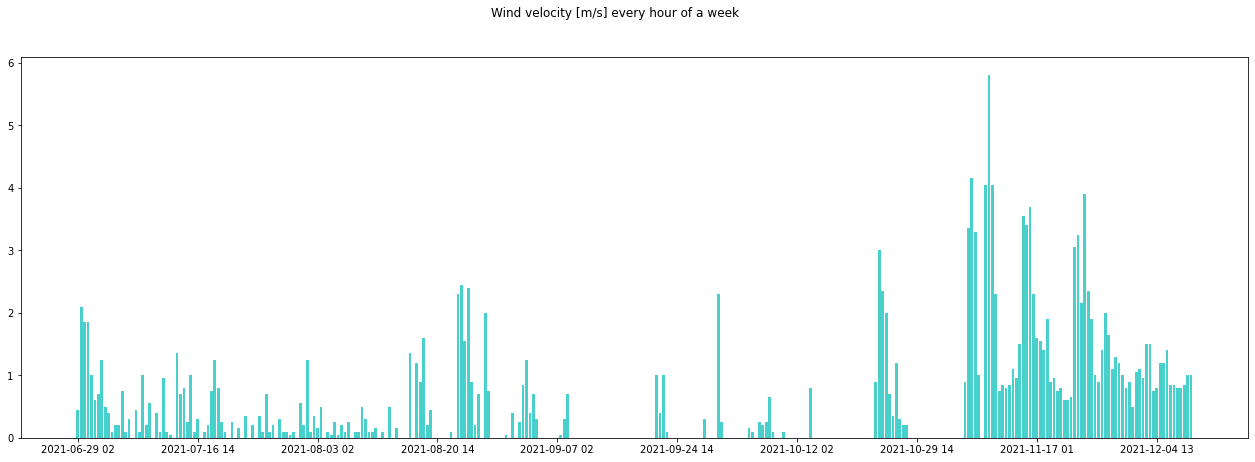

<Figure size 432x288 with 0 Axes>

In [ ]:
import statistics

wind_temp = pd.read_csv('https://raw.githubusercontent.com/marcochisci/Anomaly_detection/main/anemo.csv')
wind_temp=wind_temp.set_index('Date')
wind_temp=wind_temp.loc['2021-06-29 02:00':'2021-12-10 01:00']
wind_temp.reset_index(level=0, inplace=True)
#duplicare i dati dell'ora '2021-10-31 00:00' per evitare problemi con fuso orario
index_change=wind_temp[wind_temp['Date']=='2021-10-31 00:00'].index
print(index_change)
line = pd.DataFrame({"Date": ['2021-10-31 00:00','2021-10-31 00:15', '2021-10-31 00:30', '2021-10-31 00:45'], " Velocità [m/s]": [0,0,0,0]})
wind_temp = pd.concat([wind_temp.iloc[:11896], line, wind_temp.iloc[11896:]]).reset_index(drop=True)
wind_temp=wind_temp.drop([' Potenza'], axis=1)
#ogni 12 ore fa la media, 48 valori (ogni 15 minuti 1 valore)
num_values=48
how_many=int(len(wind_temp)/num_values)
wind_df=pd.DataFrame(columns=wind_temp.columns)
for i in range(how_many):
  values=[]
  for j in range(num_values):
    values.append(wind_temp[' Velocità [m/s]'][i*num_values+j])
  value=statistics.median(values)
  wind_df.loc[i,:]=[wind_temp['Date'][i*num_values],value]
#cambia formato delle date
for i in range(len(wind_df)):
  wind_df['Date'][i]=datetime.datetime.strptime(wind_df['Date'][i], "%Y-%m-%d %H:%M").strftime('%Y-%m-%d %H')
wind_df=wind_df.set_index('Date')
wind_df= wind_df.rename(columns={' Velocità [m/s]': 'Wind'})
display(wind_df)

# Plot
data_wind=wind_df['Wind']
plt.figure(figsize=(22, 7))
plt.bar(wind_df.index, data_wind, color='mediumturquoise', linewidth=1)
# Decorations
x_ticks = np.arange(0, len(wind_df), 35)
plt.xticks(x_ticks)
plt.suptitle('Wind velocity [m/s] every hour of a week')
plt.show()

plt.tight_layout();


Join the dataframes together, only get the rows that have all the values

In [ ]:
df=df.join(wind_df, how='outer')
df=df.dropna()
#there are two index here
display(df)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 02,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481,0.45
2021-06-29 14,485.677582,1.229219,408.007557,44.385567,30.052645,6.357683,441.720403,251.073048,226.254408,389.267003,2.1
2021-06-30 02,403.322440,1.917211,408.718954,40.068039,25.106100,9.461874,562.250545,268.991285,223.769063,356.978214,1.85
2021-06-30 14,355.258373,1.700957,405.818182,40.966938,26.467464,9.514354,408.889952,194.583732,206.466507,352.296651,1.85
2021-07-01 02,374.174312,2.975535,420.651376,36.713639,21.714679,12.700306,658.027523,309.171254,226.581040,352.969419,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 13,471.201699,31.405520,490.388535,16.172718,4.527176,44.700637,746.286624,205.861996,210.118896,366.076433,0.8
2021-12-08 01,562.745182,35.755889,501.655246,14.800535,2.230835,45.019272,981.447537,257.460385,224.274090,348.239829,0.8
2021-12-08 13,520.709130,65.781316,469.065817,18.256051,5.544798,99.751592,999.000000,253.044586,245.318471,343.836518,0.85
2021-12-09 01,334.065957,35.642553,447.497872,18.029447,5.303617,94.046809,982.810638,152.165957,228.582979,298.789362,1


# Preparations

In [ ]:
df_copy= df.copy()

In [ ]:
pip install fitter

# VAR model mahalanobis

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Non-Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Non-Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

Use the differencing on all the variables for the malahanobis distance

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 20
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


20


Calculating the errors

In [ ]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_summarymaha=str(var_fitresults.summary())
print(var_summarymaha[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     13:54:41
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    66.5108
Nobs:                     351.000    HQIC:                   53.2012
Log likelihood:          -10763.0    FPE:                9.29105e+19
AIC:                      44.4020    Det(Omega_mle):     1.00403e+18
--------------------------------------------------------------------



# Testing the mahalanobis errors' distribution and finding the thresholds

Make a histogram

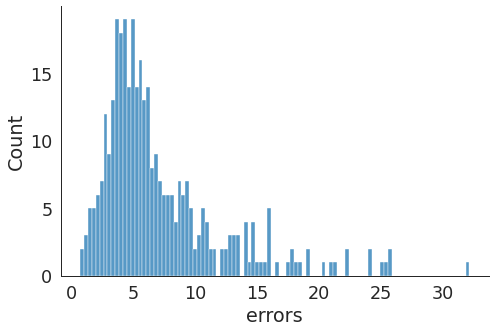

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic          bic  kl_div
lognorm          0.023410  934.166368 -3315.014655     inf
invgauss         0.025157  934.372767 -3290.040955     inf
pearson3         0.033626  962.328870 -3189.347807     inf
gamma            0.033627  962.321252 -3189.340878     inf
beta             0.034512  955.569560 -3174.473807     inf


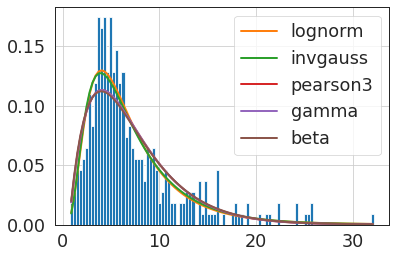

In [ ]:
er = new_errors_df["errors"].values
er_min=min(er)
er_max=max(er)
f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param=f.fitted_param[distribution]

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang

#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

threshold low: 20.007204229053265
threshold med: 25.067390676263262
threshold high: 29.20465003561735


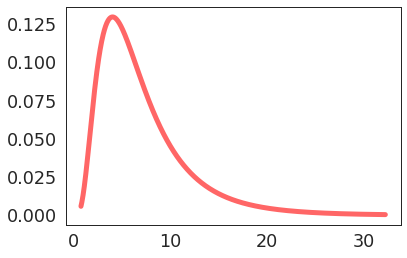

In [ ]:
from scipy.stats import invgauss
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

low, med, high= 0.975, 0.99, 0.995
find= np.linspace(er_min+((er_max-er_min)/1000),er_max*2, 2000)
x = np.linspace(er_min+((er_max-er_min)/1000),er_max, 1000)
dis=distributions[distribution]
num_var=get_num_var(distribution)
if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
#1 variables
if(num_var==1):
  c= param[0]
  loc, scale = param[1], param[2]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)
  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):        
      threshold_l=i
      found=1
    if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
#3 variables
if(num_var==2):
  c,d= param[0], param[1]
  loc, scale = param[2], param[3]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
      threshold_l=i
      found=1
    if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
print('threshold low: '+str(threshold_l))
print('threshold med: '+str(threshold_m))
print('threshold high: '+str(threshold_h))

# Finding anomalies with mahalanobis distance

In [ ]:
#0 means that is it not an anomaly
def find_anomalies(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i].values >= threshold_low) &(errors.iloc[i].values < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i].values >= threshold_med) &(errors.iloc[i].values < threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i].values >= threshold_high):
      predictions.iloc[i]=3
  return predictions

predictions = find_anomalies(abs(errors_df),threshold_l, threshold_m, threshold_h)

Select how many values do you want to predict: there are 2 values each day.

In [ ]:
data = df_copy.iloc[selected_lag: , :]
data['Predictions'] = predictions.values
how_many=72
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-11-26 01,456.306210,11.713062,456.593148,21.925675,9.766167,13.406852,997.912206,240.907923,229.605996,344.847966,0.0
2021-11-26 13,250.106291,6.427332,413.212581,22.689371,10.805206,9.245119,982.405640,105.744035,221.678959,309.856833,0.0
2021-11-27 01,49.643777,2.995708,396.587983,22.154721,10.933262,13.828326,805.431330,18.783262,205.446352,250.300429,0.0
2021-11-27 13,131.200855,4.506410,406.455128,21.040620,9.320299,8.485043,974.884615,70.762821,223.976496,287.446581,0.0
2021-11-28 01,173.408120,7.628205,417.098291,20.062201,8.334829,12.581197,925.205128,72.485043,220.102564,288.967949,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29 13,502.731915,26.674468,476.804255,22.626723,10.957447,34.761702,998.961702,261.759574,270.221277,346.091489,0.0
2021-12-30 01,513.302575,43.502146,499.454936,19.117618,6.269313,94.645923,999.000000,273.725322,247.472103,327.557940,0.0
2021-12-30 13,485.230769,73.895299,497.309829,20.570427,7.918803,242.775641,999.000000,261.452991,253.525641,331.465812,2.0


In [ ]:
data['Predictions'].value_counts()

0.0    60
1.0     5
3.0     4
2.0     3
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance with graphs, differenced values

get all the anomalies

In [ ]:
anomalies_l= df.iloc[-how_many:][(data['Predictions'] == 1)]
anomalies_m= df.iloc[-how_many:][(data['Predictions'] == 2)]
anomalies_h= df.iloc[-how_many:][(data['Predictions'] == 3)]

Get the days before to compare

In [ ]:
day_before= df.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

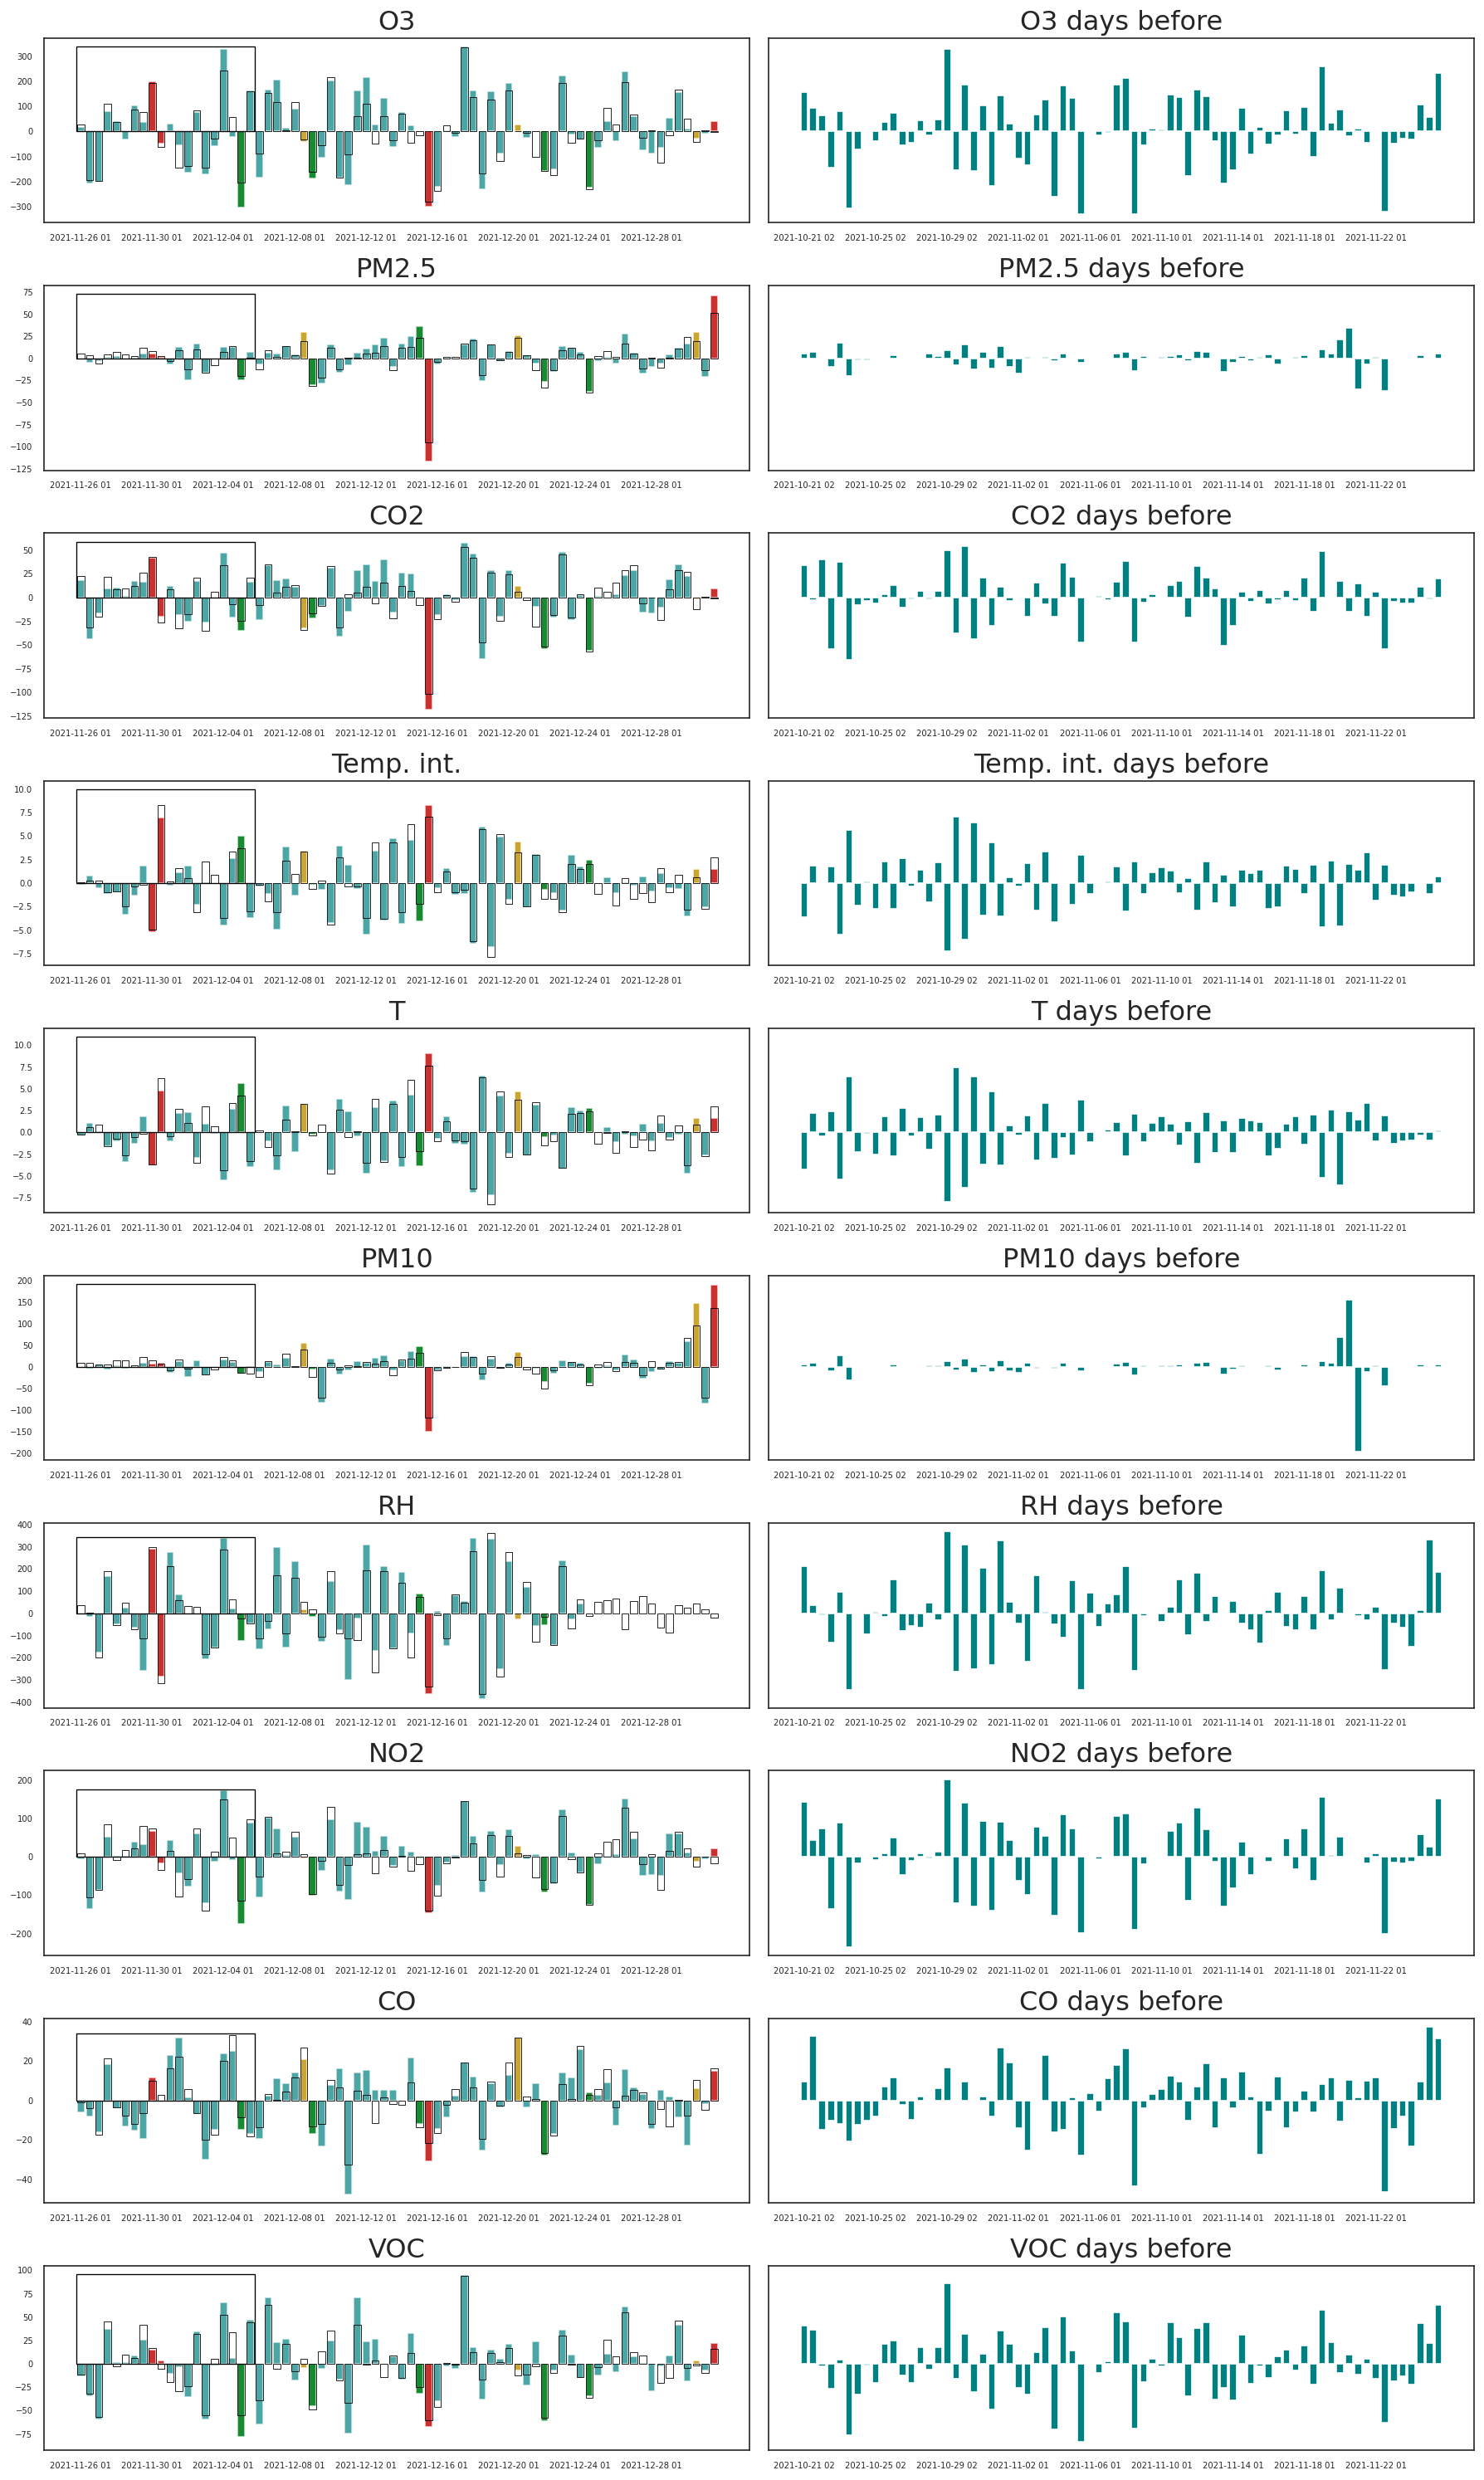

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = df.iloc[-how_many:][df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', alpha=0.7, linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',alpha=0.7,  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(df.iloc[-how_many:][df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      data_expeted= var_fit_df.iloc[-how_many:][df.columns[i/2]]
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();


# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [ ]:
anomalies_l= data[(data['Predictions'] == 1)]
anomalies_m= data[(data['Predictions'] == 2)]
anomalies_h= data[(data['Predictions'] == 3)]

Get the days before to compare

In [ ]:
day_before= df_copy.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

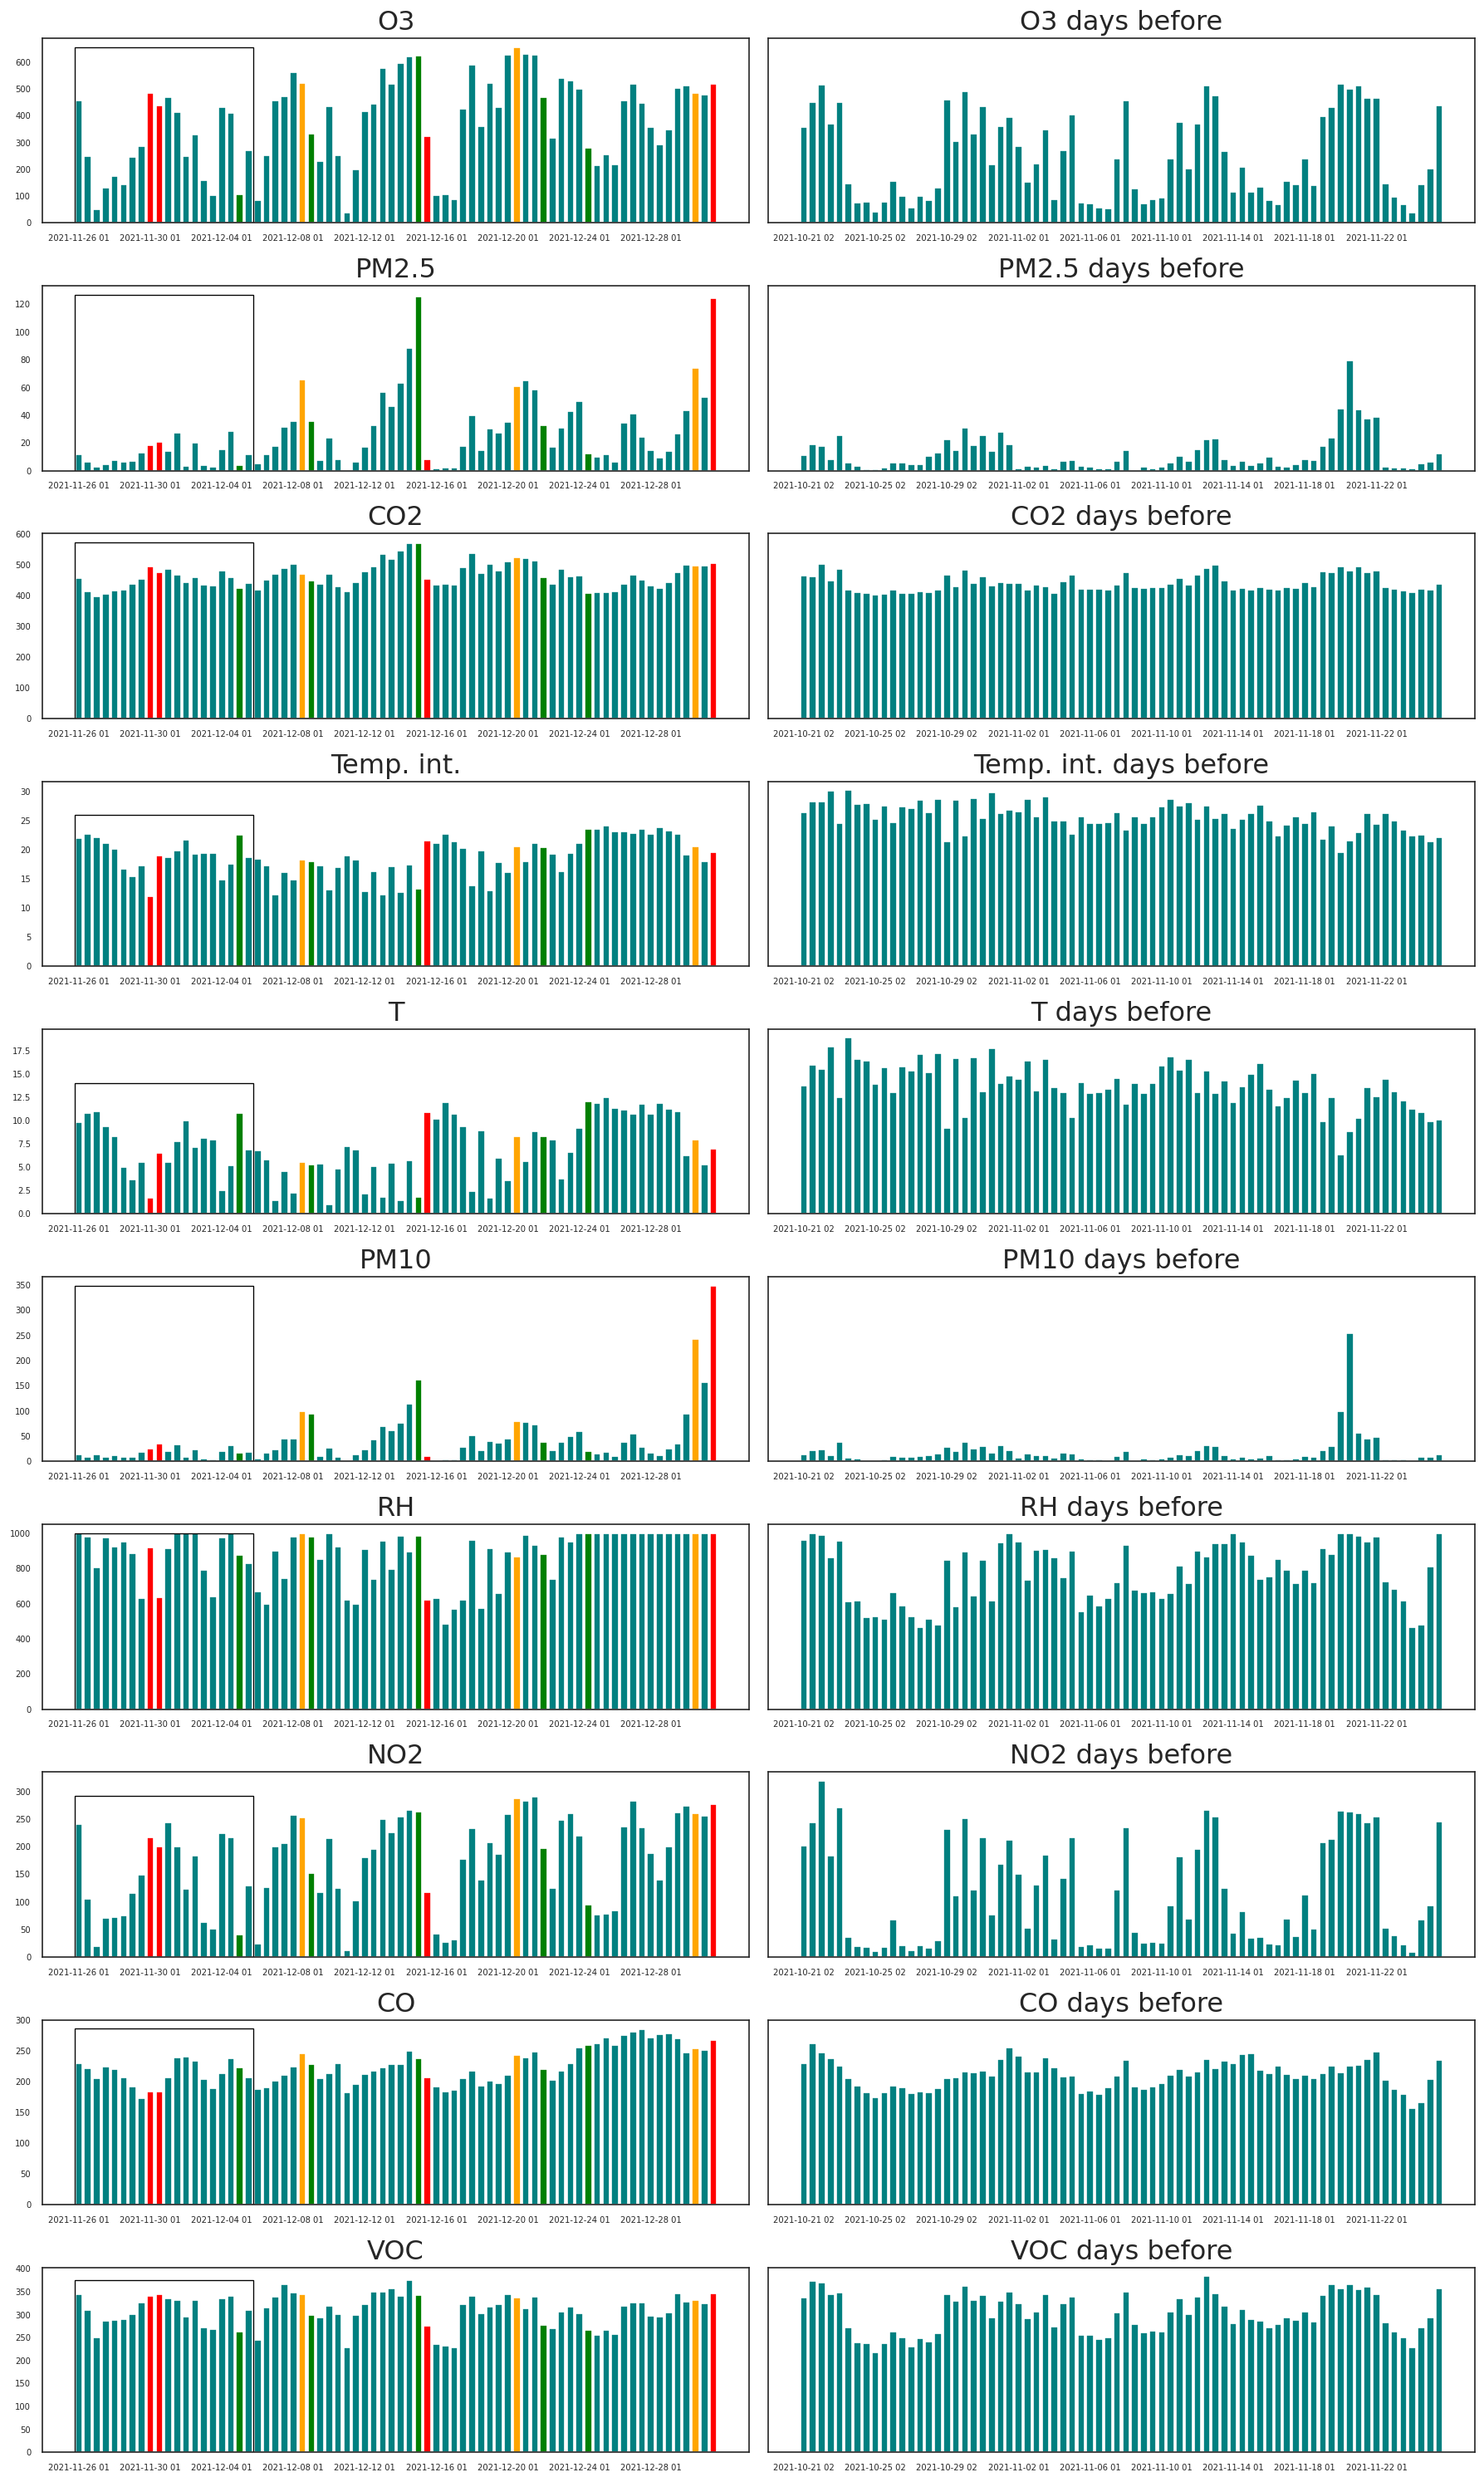

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = data[df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green',  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(data[df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();


# Searching the anomalies using the euclidian distance for each variable

Testing stationarity

In [ ]:
df_e=df_copy.copy()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_e, col)
    for col in df_e.columns
}
adf_test_results     

{'CO': 'Non-Stationary',
 'CO2': 'Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing.

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df_e.columns:
    df_e[col] = differencing(df_e, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 28
var_model = VAR(df_e)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag_eucl = lag_results.aic
print(selected_lag_eucl)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


28


In [ ]:
import numpy as np
import scipy as sp

#euclidian distance
def euclidian(x=None, data=None):
  distance = pd.DataFrame(index=df_copy.index[selected_lag_eucl:], columns=data.columns)
  for col in data.columns:
    distance[col]=abs((x[col]).values-(data[col]).values)
  return distance
var = VAR(df_e)
var_fitresults = var.fit(selected_lag_eucl)
var_summaryeucl=str(var_fitresults.summary())
print(var_summaryeucl[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag_eucl:], columns=df_e.columns)
distance = euclidian(x=var_fit_df, data= df_e.iloc[selected_lag_eucl:])
display(distance)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Jan, 2022
Time:                     17:33:18
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    61.4873
Nobs:                     299.000    HQIC:                   40.6299
Log likelihood:          -5425.86    FPE:                3.30239e+18
AIC:                      26.7106    Det(Omega_mle):     4.37784e+15
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-13 02,9.857558,0.877228,2.865151,0.345489,0.445094,0.935031,12.159368,8.139815,0.314414,2.502487
2021-07-13 14,19.405797,0.751144,2.484000,0.839409,0.841539,0.515581,46.203509,15.773311,3.002705,4.930566
2021-07-14 02,18.345767,0.255376,2.680171,0.047288,0.136304,0.192346,7.589901,10.662958,2.179709,9.474434
2021-07-14 14,7.756440,1.117998,3.752974,0.850619,0.884686,5.100216,11.805524,12.920672,2.833907,0.499909
2021-07-15 02,26.493387,0.144225,6.270274,0.080808,0.028032,1.097035,11.289342,26.225541,2.290729,10.361093
...,...,...,...,...,...,...,...,...,...,...
2021-12-07 13,11.690162,0.332935,1.694066,0.076507,0.010625,1.651017,3.389511,7.670791,0.827251,3.258254
2021-12-08 01,6.342061,0.353863,3.438667,0.123610,0.206421,0.561192,11.680240,9.240530,0.307103,1.435246
2021-12-08 13,9.089426,1.300617,4.417375,0.566036,0.634546,5.280375,4.105177,10.260862,2.003067,2.573346


# Distributions function code

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang
import matplotlib.pyplot as plt



Get how many variables the distribution needs to work correctly

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

Function used to get the thresholds

In [ ]:
def get_thresholds(dis, param, min, max,num_var):
  low, med, high= 0.975,0.99,0.995
  find= np.linspace(min+((max-min)/1000),max*2, 2000)
  x = np.linspace(min+((max-min)/1000),max, 1000)
  fig, ax = plt.subplots(1, 1)
  #0 variables
  if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #1 variables
  if(num_var==1):
    c= param[0]
    loc, scale = param[1], param[2]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #3 variables
  if(num_var==2):
    c,d= param[0], param[1]
    loc, scale = param[2], param[3]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  return threshold_l, threshold_m, threshold_h

# Testing the distance's distributions and finding the thresholds

Make histograms

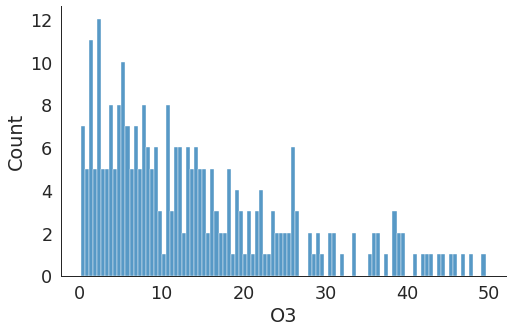

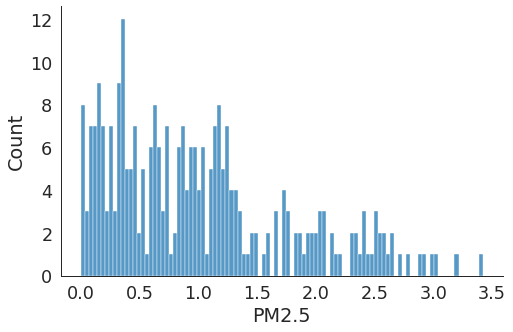

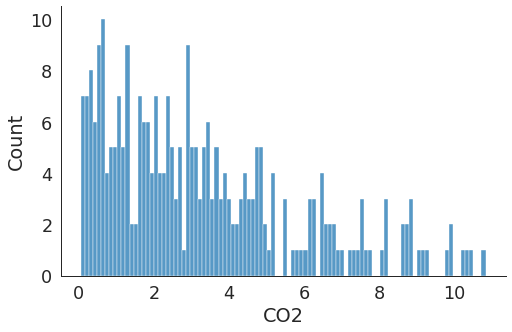

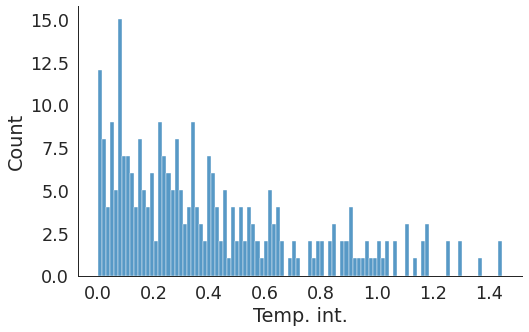

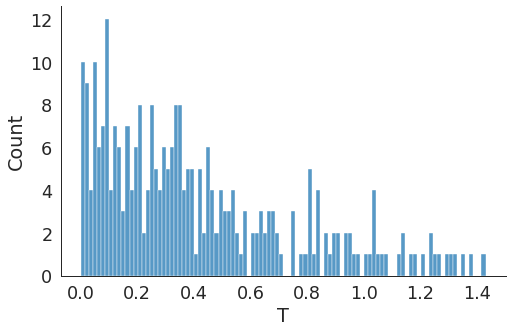

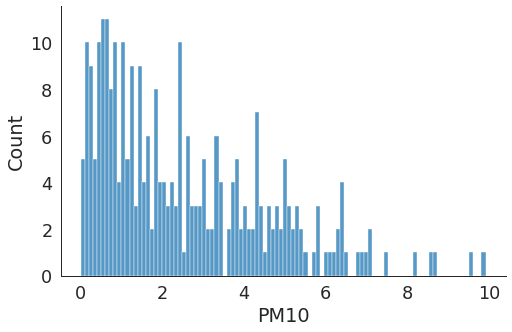

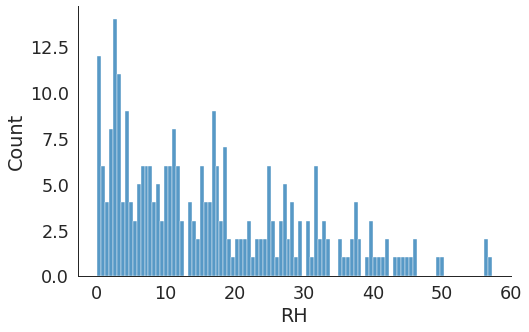

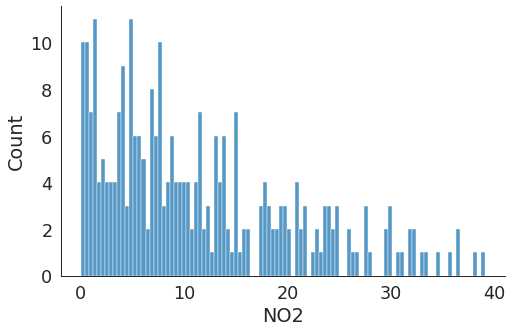

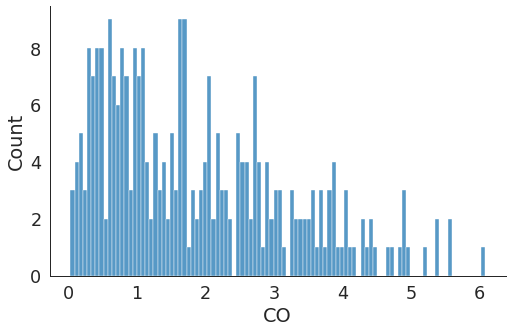

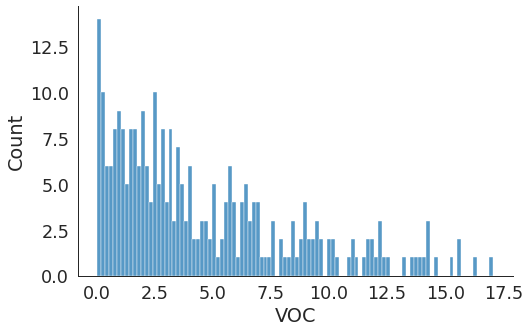

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic          bic  kl_div
gamma            0.011376  888.137419 -2858.607491     inf
pearson3         0.011376  888.138118 -2858.607418     inf
beta             0.011842  871.766494 -2841.568934     inf
expon            0.012616  886.437017 -2834.873043     inf
burr             0.012749  901.907727 -2820.610262     inf


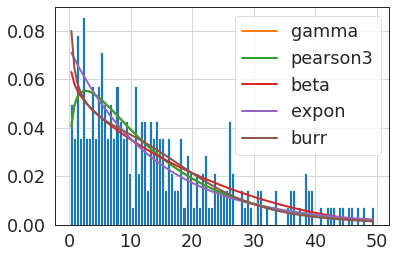

In [ ]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_O=f.fitted_param[distribution]

47.04962480589499 57.83596858635122 65.95046574229077


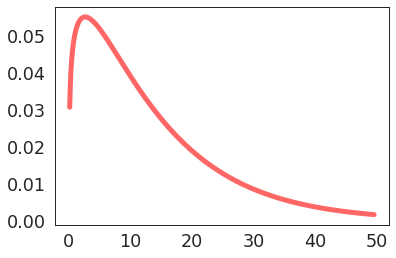

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_O3_l, threshold_O3_m, threshold_O3_h= get_thresholds(dis, param_O, O3_min, O3_max,num_var)
print(threshold_O3_l, threshold_O3_m, threshold_O3_h)


             sumsquare_error         aic          bic  kl_div
beta                3.310394  335.789145 -1241.745699     inf
weibull_min         3.398732  345.394146 -1239.915497     inf
pearson3            3.468236  346.585619 -1234.166237     inf
gamma               3.468282  346.592071 -1234.162512     inf
burr                3.484302  347.349770 -1227.204742     inf


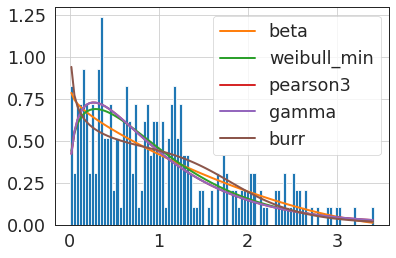

In [ ]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_P=f.fitted_param[distribution]

2.7810903999411467 3.0444715817628927 3.188134044574754


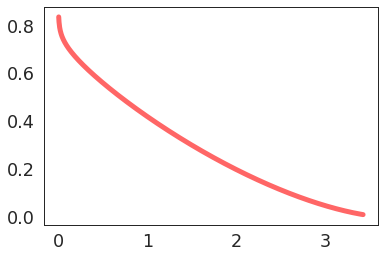

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM2_l, threshold_PM2_m, threshold_PM2_h= get_thresholds(dis, param_P, PM2_min, PM2_max,num_var)
print(threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)


             sumsquare_error         aic          bic  kl_div
beta                0.235621  562.235130 -1992.243472     inf
burr                0.238953  582.276591 -1988.255412     inf
weibull_min         0.242634  570.430132 -1989.563158     inf
pearson3            0.246585  572.579610 -1984.975764     inf
gamma               0.246587  572.580609 -1984.973110     inf


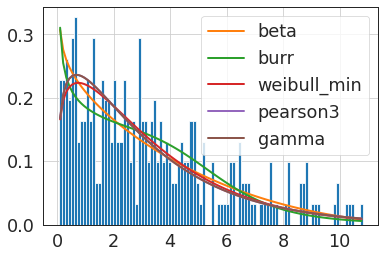

In [ ]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO2=f.fitted_param[distribution]

9.447545293142774 10.613596096268903 11.30458916478809


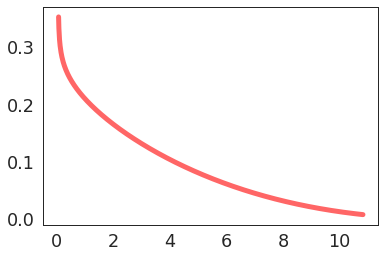

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO2_l, threshold_CO2_m, threshold_CO2_h= get_thresholds(dis, param_CO2, CO2_min, CO2_max,num_var)
print(threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)


             sumsquare_error         aic         bic  kl_div
beta               16.833414  165.440527 -779.876896     inf
expon              17.284670  182.013396 -783.661860     inf
gamma              17.302677  183.470890 -777.717168     inf
pearson3           17.302874  183.477359 -777.713931     inf
weibull_min        17.363584  182.328264 -776.719229     inf


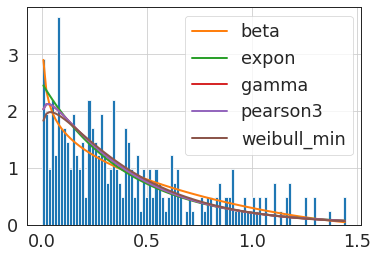

In [ ]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_Temp= f.fitted_param[distribution]

1.2032044082677327 1.3261569991646 1.394142549425221


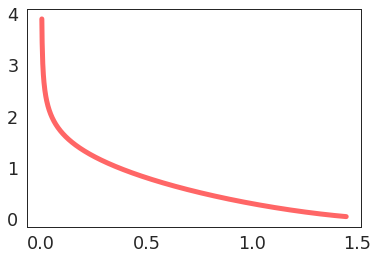

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_Temp_l, threshold_Temp_m, threshold_Temp_h= get_thresholds(dis, param_Temp, Temp_min, Temp_max,num_var)
print(threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

             sumsquare_error         aic         bic  kl_div
beta               14.293156  158.171569 -826.335037     inf
weibull_min        14.726941  172.910565 -823.493048     inf
gamma              14.756901  174.611468 -822.915881     inf
pearson3           14.756968  174.620203 -822.914589     inf
expon              14.843994  173.862459 -826.893649     inf


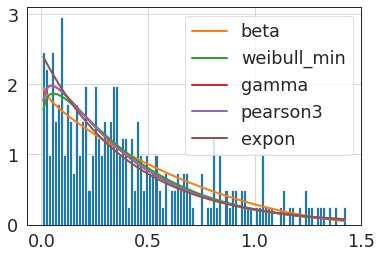

In [ ]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_T=f.fitted_param[distribution]

1.2037740054774697 1.338129906518553 1.4167424018085484


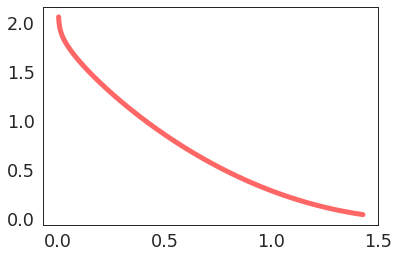

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_T_l, threshold_T_m, threshold_T_h= get_thresholds(dis, param_T, T_min, T_max,num_var)
print(threshold_T_l, threshold_T_m, threshold_T_h)

             sumsquare_error         aic          bic  kl_div
beta                0.361423  588.722715 -1870.741385     inf
gamma               0.363048  588.346683 -1875.115932     inf
pearson3            0.363052  588.351388 -1875.113040     inf
weibull_min         0.367788  589.318539 -1871.432404     inf
expon               0.392367  581.940930 -1858.708814     inf


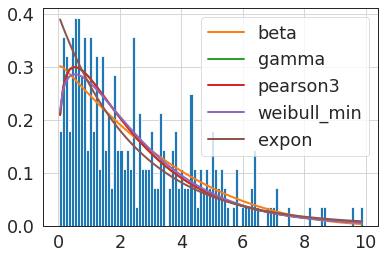

In [ ]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_PM10=f.fitted_param[distribution]

7.510768525421936 8.492291130911223 9.097067685808662


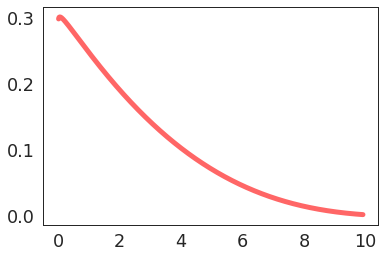

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM10_l, threshold_PM10_m, threshold_PM10_h= get_thresholds(dis, param_PM10, PM10_min, PM10_max,num_var)
print(threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)


          sumsquare_error         aic          bic  kl_div
beta             0.012186  890.816527 -2833.424680     inf
burr             0.012614  940.954017 -2823.631817     inf
expon            0.013076  911.763019 -2824.707890     inf
gamma            0.013203  912.780511 -2816.325909     inf
pearson3         0.013203  912.780595 -2816.325638     inf


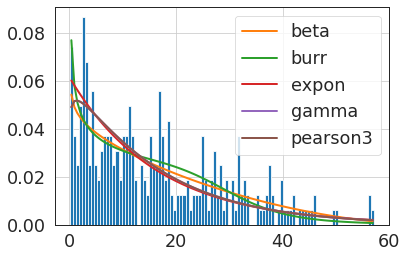

In [ ]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_RH=f.fitted_param[distribution]

48.74118315202407 53.88061910981526 56.7929661525636


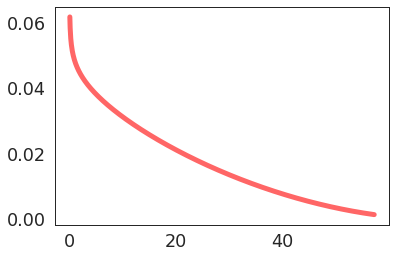

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_RH_l, threshold_RH_m, threshold_RH_h= get_thresholds(dis, param_RH, RH_min, RH_max,num_var)
print(threshold_RH_l, threshold_RH_m, threshold_RH_h)


          sumsquare_error         aic          bic  kl_div
burr             0.023097  840.226257 -2651.833633     inf
beta             0.023161  827.297262 -2651.058019     inf
expon            0.025013  833.777148 -2640.501168     inf
pearson3         0.025191  834.371968 -2632.841940     inf
gamma            0.025191  834.371417 -2632.841934     inf


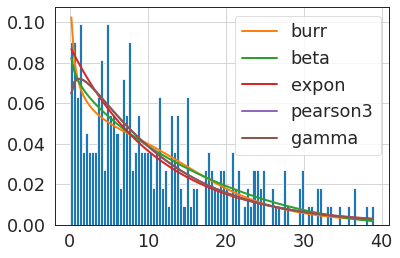

In [ ]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_NO2=f.fitted_param[distribution]

39.26642591409709 51.87117537163103 63.656420994464625


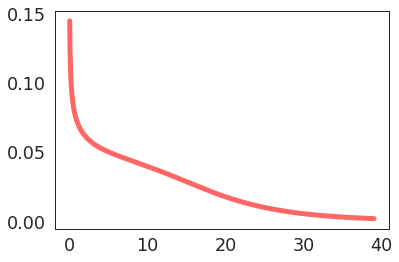

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_NO2_l, threshold_NO2_m, threshold_NO2_h= get_thresholds(dis, param_NO2, NO2_min, NO2_max,num_var)
print(threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

             sumsquare_error         aic          bic  kl_div
beta                0.917509  446.917524 -1606.163079     inf
weibull_min         0.932561  453.303482 -1607.190964     inf
gamma               0.932920  455.212398 -1607.081625     inf
pearson3            0.932926  455.215712 -1607.079583     inf
triang              0.980018  418.137522 -1593.094100     inf


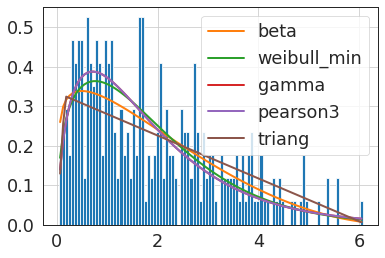

In [ ]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO=f.fitted_param[distribution]

4.95109850649467 5.448172757482145 5.733081169633503


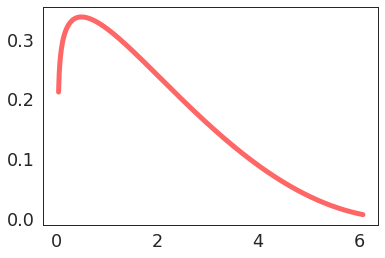

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO_l, threshold_CO_m, threshold_CO_h= get_thresholds(dis, param_CO, CO_min, CO_max,num_var)
print(threshold_CO_l, threshold_CO_m, threshold_CO_h)

             sumsquare_error         aic          bic  kl_div
burr                0.083356  700.926129 -2287.350295     inf
gamma               0.088279  684.225775 -2276.702544     inf
pearson3            0.088312  683.863721 -2276.595455     inf
expon               0.088385  681.482510 -2282.010998     inf
weibull_min         0.090165  682.852217 -2270.699134     inf


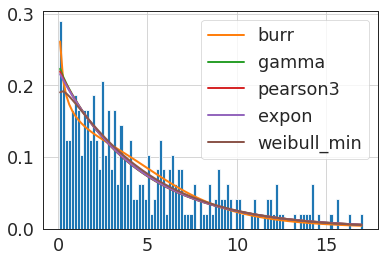

In [ ]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_VOC=f.fitted_param[distribution]

16.255863627596646 22.10469142763083 27.74889551454428


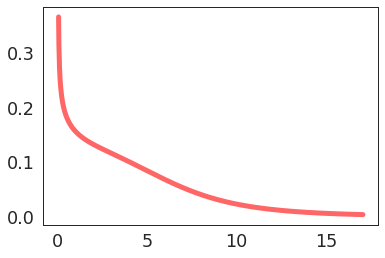

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_VOC_l, threshold_VOC_m, threshold_VOC_h= get_thresholds(dis, param_VOC, VOC_min, VOC_max,num_var)
print(threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)


# Using the thresholds to search anomalies 

In [ ]:
to_show=72
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

data_thresh=df_copy.iloc[-to_show:,:]

Finding anomalies with the burr distribution (O3)

In [ ]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.iloc[-to_show:,:].values
data_thresh['Predictions_O3'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    71
1.0     1
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [ ]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.iloc[-to_show:,:].values
data_thresh['Predictions_PM2.5'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    68
3.0     3
1.0     1
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [ ]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.iloc[-to_show:,:].values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
2.0     1
3.0     1
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [ ]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp. int.'] = predictions_Temp.iloc[-to_show:,:].values
data_thresh['Predictions_Temp. int.'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    66
1.0     5
3.0     1
Name: Predictions_Temp. int., dtype: int64

Finding anomalies with the burr distribution (T)


In [ ]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.iloc[-to_show:,:].values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    67
3.0     2
2.0     2
1.0     1
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [ ]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.iloc[-to_show:,:].values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    69
3.0     2
2.0     1
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [ ]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.iloc[-to_show:,:].values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    72
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [ ]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.iloc[-to_show:,:].values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    71
2.0     1
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [ ]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.iloc[-to_show:,:].values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    71
3.0     1
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [ ]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.iloc[-to_show:,:].values
data_thresh['Predictions_VOC'].value_counts()
display(data_thresh[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions_O3,Predictions_PM2.5,Predictions_CO2,Predictions_Temp. int.,Predictions_T,Predictions_PM10,Predictions_RH,Predictions_NO2,Predictions_CO,Predictions_VOC
Dates,,,,,,,,,,,,,,,,,,,,
2021-11-15 01,117.292208,3.863636,419.632035,26.266602,14.965801,5.534632,878.367965,34.677489,246.339827,289.500000,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-11-15 13,135.542553,5.646809,427.870213,27.685702,16.167234,7.680851,741.272340,36.070213,218.868085,286.446809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-16 01,83.814499,9.918977,421.266525,24.921087,13.410661,11.484009,755.085288,23.936034,213.232409,271.486141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-16 13,69.853503,3.101911,418.307856,22.335117,11.556051,3.547771,853.157113,22.078556,225.537155,279.331210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-17 01,155.529801,3.026490,426.434879,24.218918,12.501104,4.103753,791.041943,69.640177,211.719647,294.463576,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-17 13,144.191398,4.651613,423.036559,25.699720,14.367312,5.901075,714.926882,37.946237,205.860215,287.533333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-18 01,240.054585,8.331878,444.233624,24.583035,13.005459,10.978166,794.360262,112.960699,210.882096,306.893013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-18 13,139.442060,7.242489,428.965665,26.477296,15.081116,8.862661,720.321888,50.291845,205.100858,284.834764,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
2021-11-19 01,398.609914,17.607759,477.743534,21.763707,9.875216,21.715517,915.191810,207.665948,213.495690,342.439655,1.0,3.0,3.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0


Create a table with results and differenced data

In [ ]:
data_diff=data_thresh.copy()
for col in df_copy.columns:
  data_diff[col]=df_e[col].iloc[-to_show:]

# Showing the anomalies (differenced values) found with the euclidian distance with graphs

In [ ]:
show_data_diff=data_diff.iloc[-to_show:,:]
day_before= df_e.iloc[-(to_show*2):-to_show,:]
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show, 8)

Using this differencing out[i] = arr[i+1] – arr[i]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_diff.index, 0)
      data_temp = show_data_diff[(data_diff['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal',alpha=0.7, linewidth=1)
      data_expeted= var_fit_df[col].iloc[-to_show:]
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_diff[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)


      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


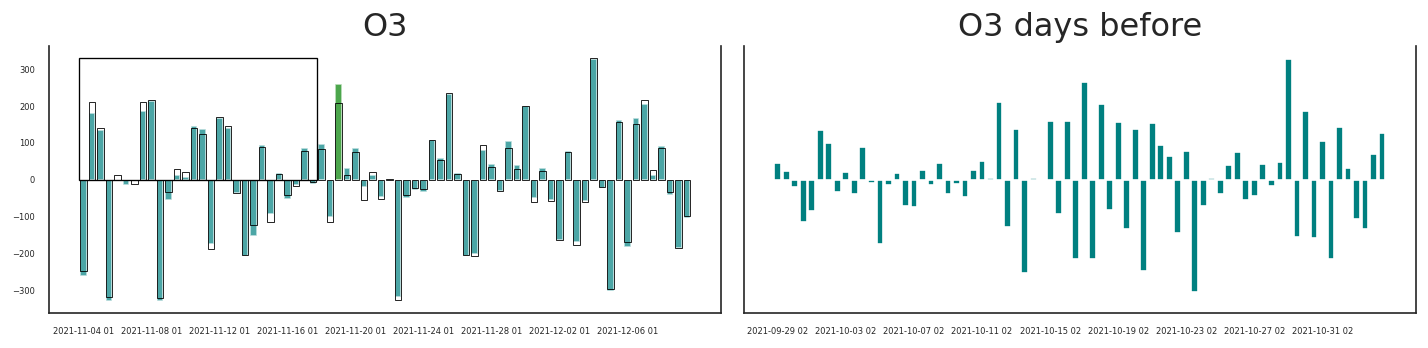

In [ ]:
anomalies_O3_l= show_data_diff[(data_diff['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_diff[(data_diff['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_diff[(data_diff['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

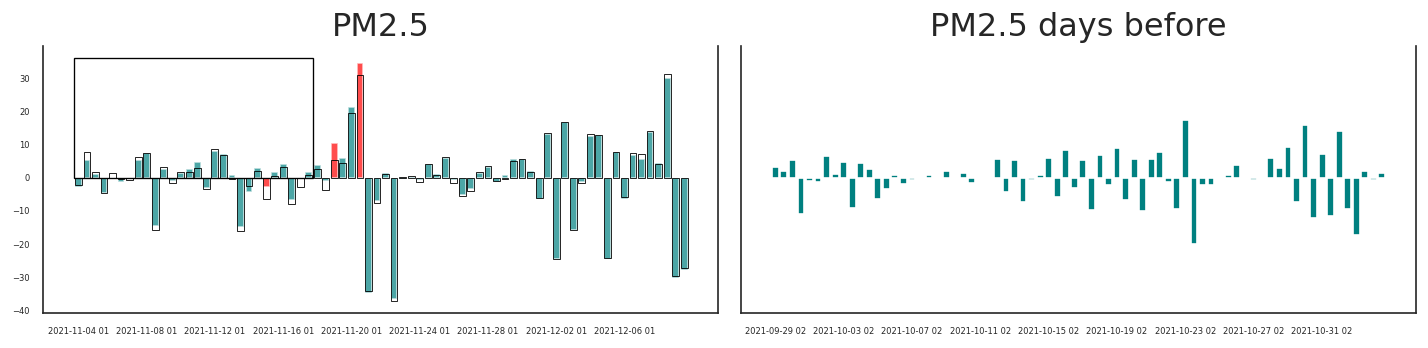

In [ ]:
anomalies_PM2_l= show_data_diff[(data_diff['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_diff[(data_diff['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_diff[(data_diff['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

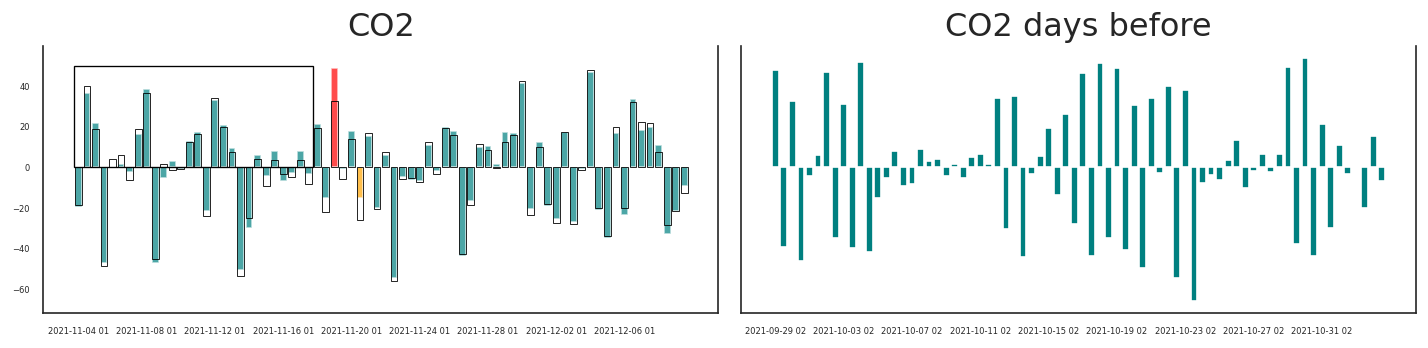

In [ ]:
anomalies_CO2_l= show_data_diff[(data_diff['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_diff[(data_diff['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_diff[(data_diff['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

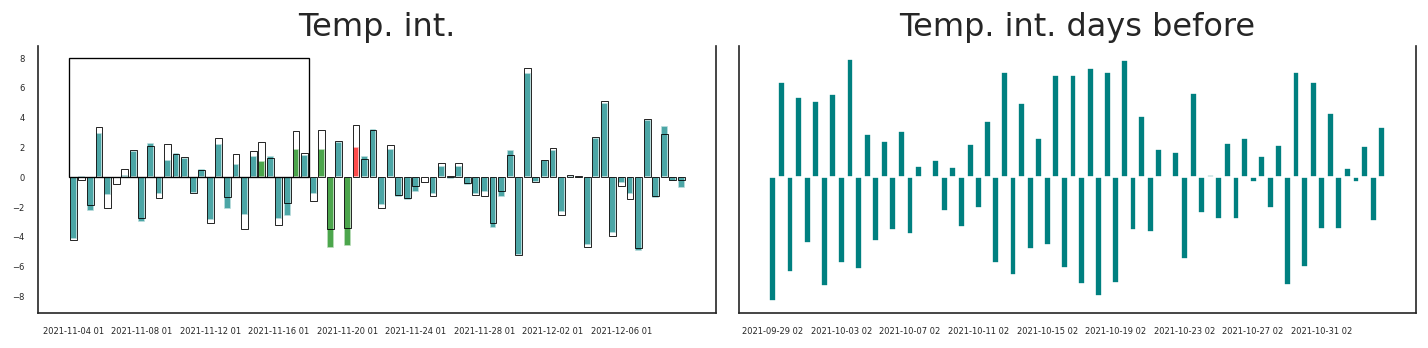

In [ ]:
anomalies_Temp_l= show_data_diff[(data_diff['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_diff[(data_diff['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_diff[(data_diff['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

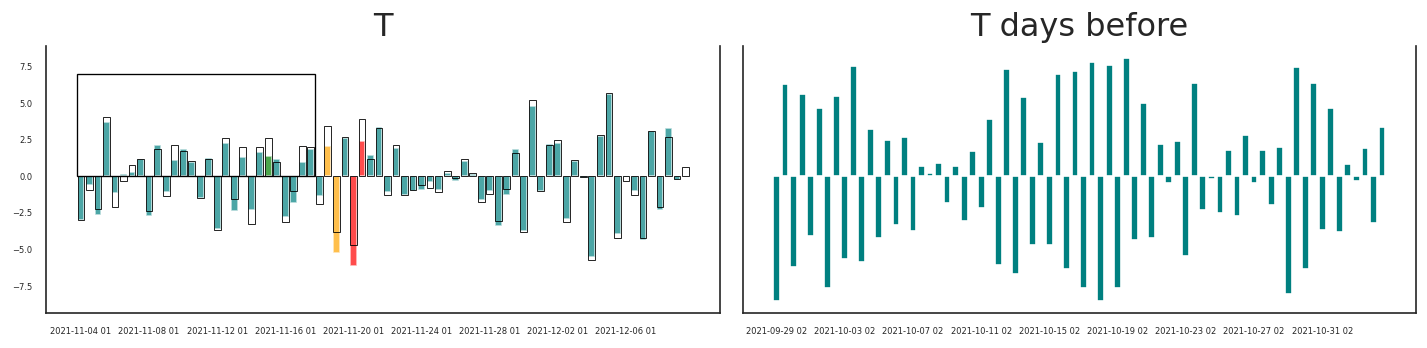

In [ ]:
anomalies_T_l= show_data_diff[(data_diff['Predictions_T'] == 1)]
anomalies_T_m= show_data_diff[(data_diff['Predictions_T'] == 2)]
anomalies_T_h= show_data_diff[(data_diff['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

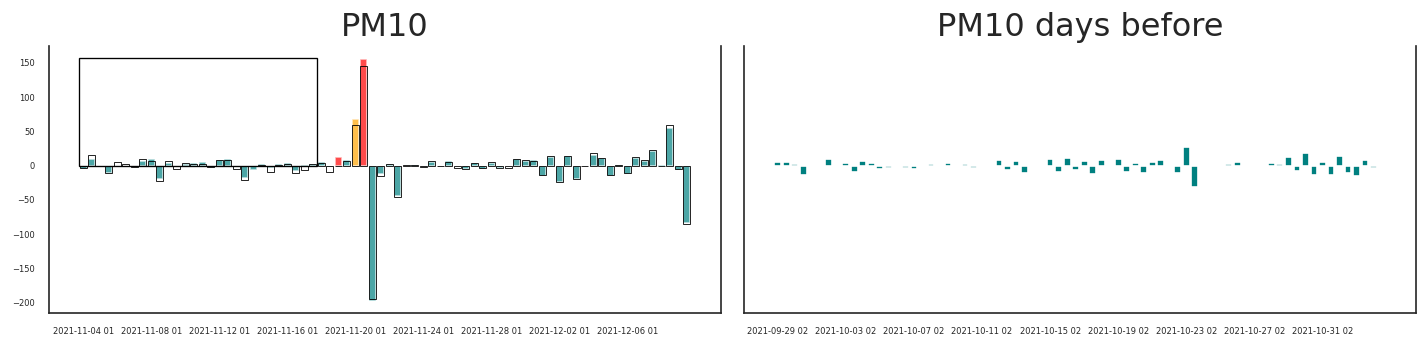

In [ ]:
anomalies_PM10_l= show_data_diff[(data_diff['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_diff[(data_diff['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_diff[(data_diff['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

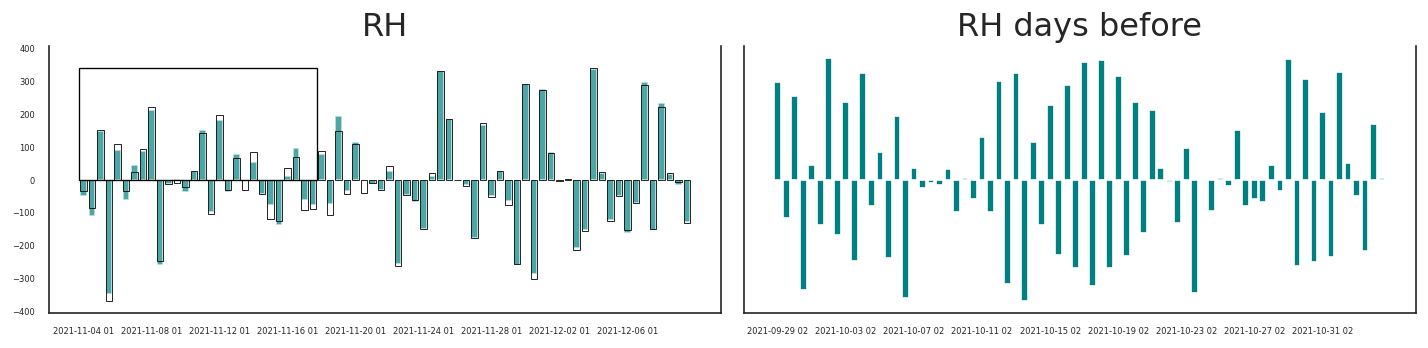

In [ ]:
anomalies_RH_l= show_data_diff[(data_diff['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_diff[(data_diff['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_diff[(data_diff['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

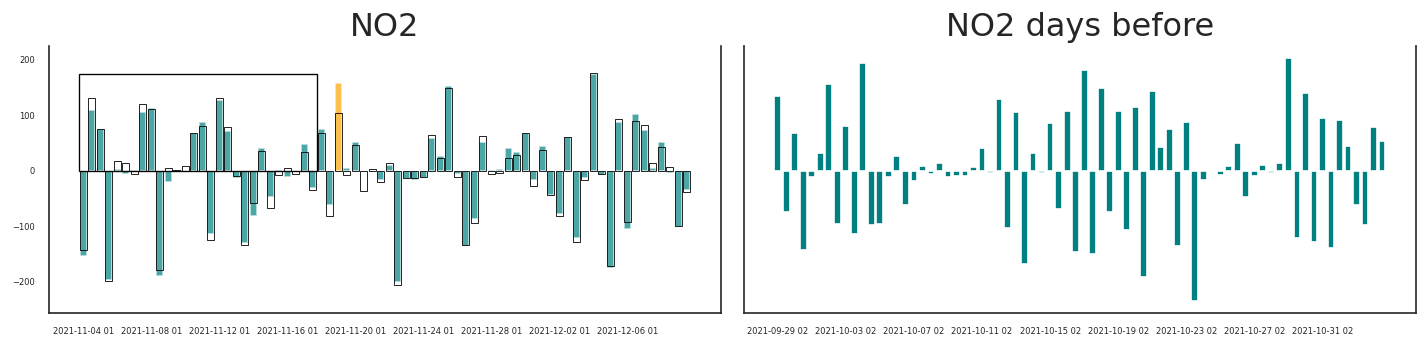

In [ ]:
anomalies_NO2_l= show_data_diff[(data_diff['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_diff[(data_diff['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_diff[(data_diff['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

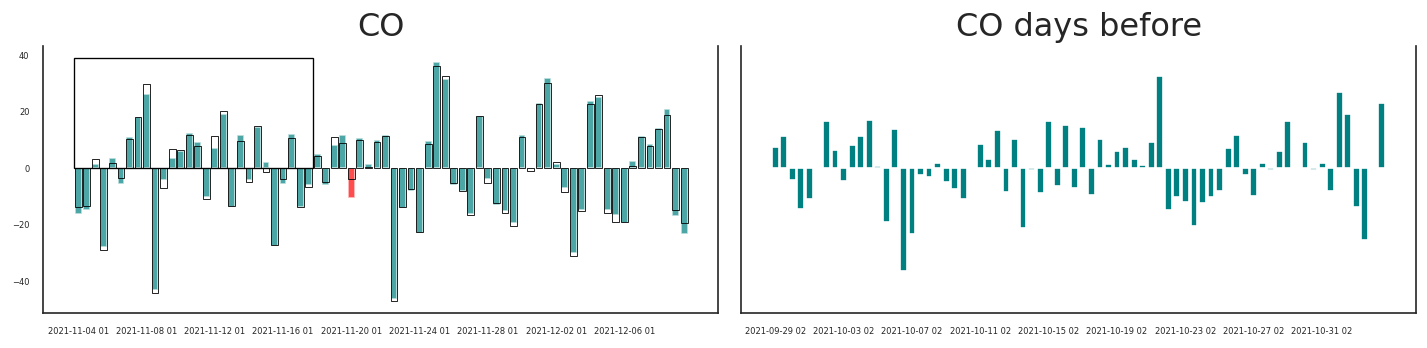

In [ ]:
anomalies_CO_l= show_data_diff[(data_diff['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_diff[(data_diff['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_diff[(data_diff['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

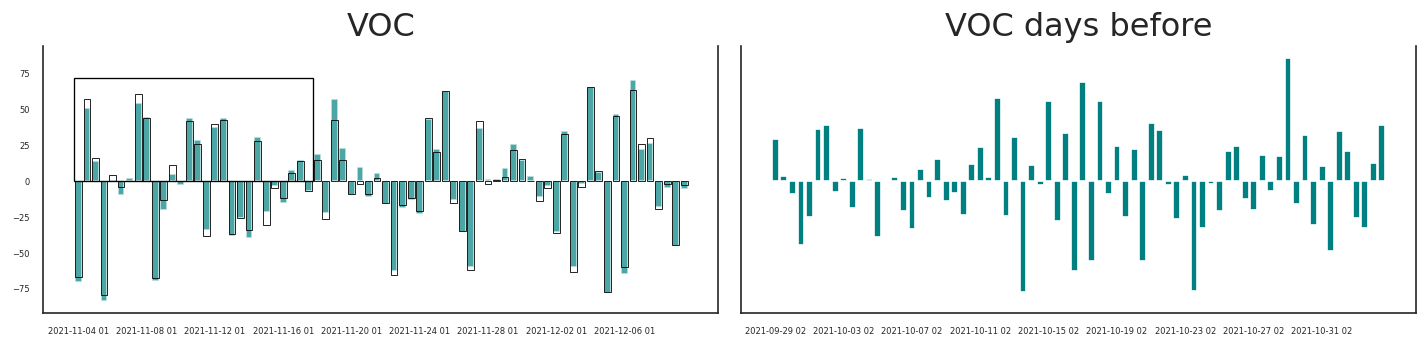

In [ ]:
anomalies_VOC_l= show_data_diff[(data_diff['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_diff[(data_diff['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_diff[(data_diff['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Showing the anomalies found with the euclidian distance with graphs

Reverse differencing the predicted values

In [ ]:
diff_range=6
many_times=to_show/diff_range
difference = pd.DataFrame(index=df_copy.index[-to_show:], columns=df_copy.columns)
for i in range(int(many_times)):
  if(i==many_times-1):
    temp = pd.DataFrame(index=df_copy.index[-diff_range-1:], columns=df_copy.columns)
  else:
    temp = pd.DataFrame(index=df_copy.index[-to_show-1+diff_range*i:-to_show+diff_range*(i+1)], columns=df_copy.columns)
  for col in df_copy.columns:
    if(i==many_times-1):
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-diff_range:][col]
    else:
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-to_show+diff_range*i:-to_show+diff_range*(i+1)][col]
    temp[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  temp=temp.iloc[-diff_range:]
  if(i==many_times-1):
    difference.iloc[-diff_range:]=temp
  else:
    difference.iloc[-to_show+diff_range*i:-to_show+diff_range*(i+1)]=temp

In [ ]:
show_data_thresh=data_thresh.iloc[-to_show:,:]
day_before= df_copy.iloc[-(to_show*2):-to_show,:]
#lines= np.arange(0, to_show, diff_range)
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show, 8)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_thresh.index, 0)
      data_temp = show_data_thresh[(data_thresh['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal', alpha=1, linewidth=1)
      #ax.bar(difference[col].index, difference[col] ,color='black', alpha=0.5, linewidth=1)
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', alpha=1, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      #lines
      #for j in range(len(lines)):
       # ax.axvline(lines[j]	, color='black', alpha=0.3)

      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


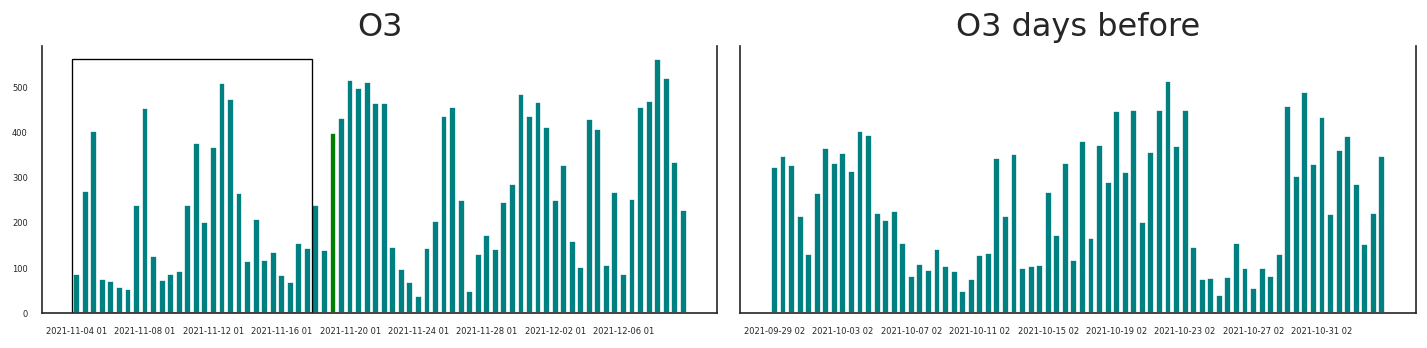

In [ ]:
anomalies_O3_l= show_data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_thresh[(data_thresh['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

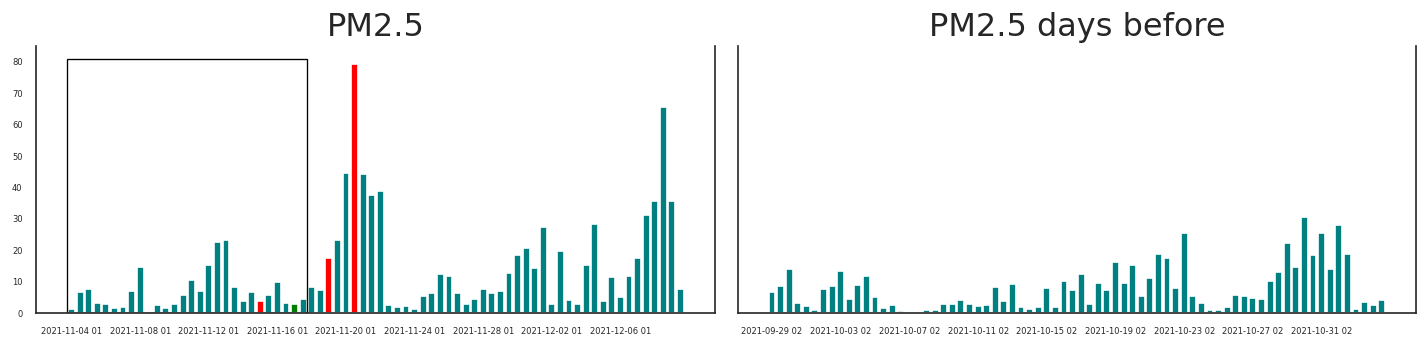

In [ ]:
anomalies_PM2_l= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

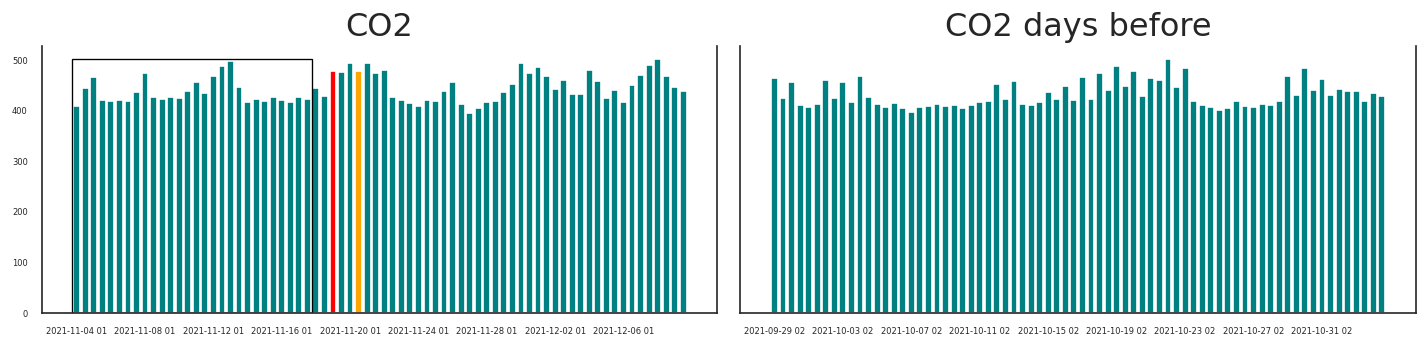

In [ ]:
anomalies_CO2_l= show_data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_thresh[(data_thresh['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

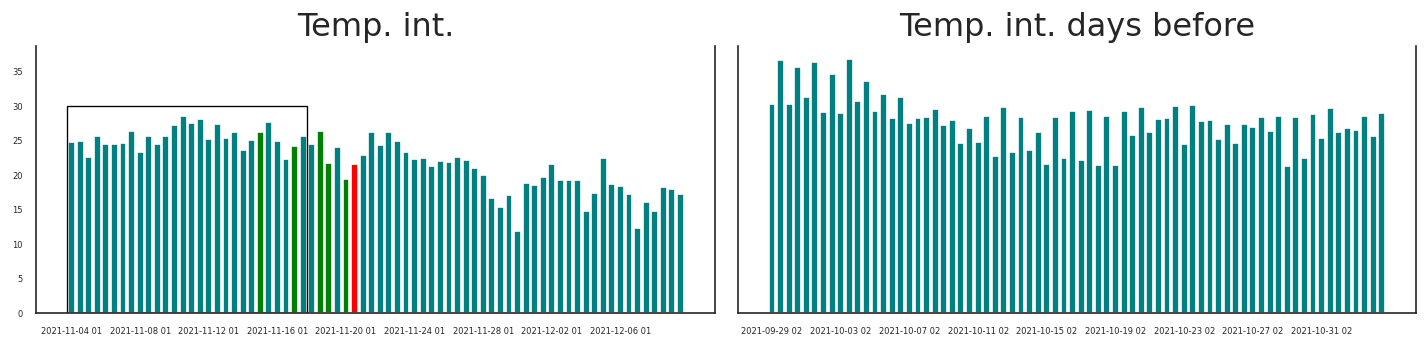

In [ ]:
anomalies_Temp_l= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

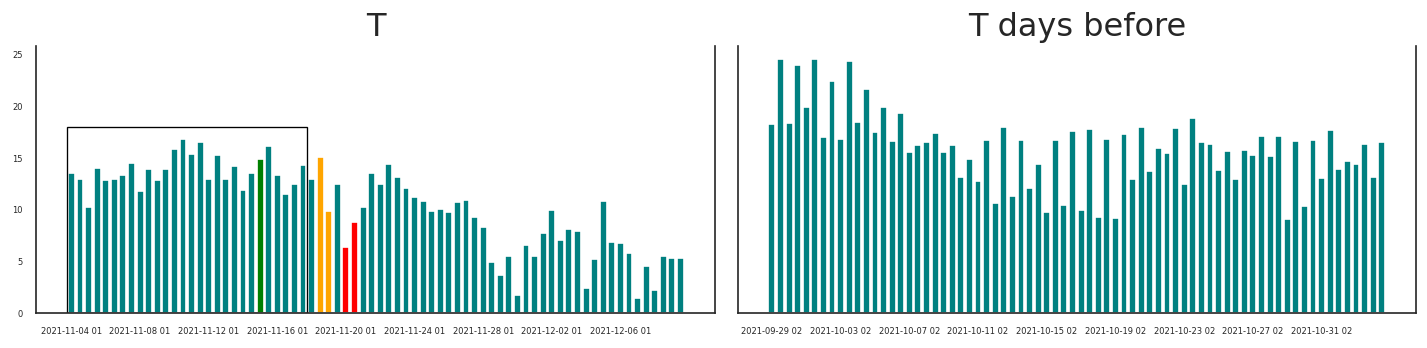

In [ ]:
anomalies_T_l= show_data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= show_data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= show_data_thresh[(data_thresh['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

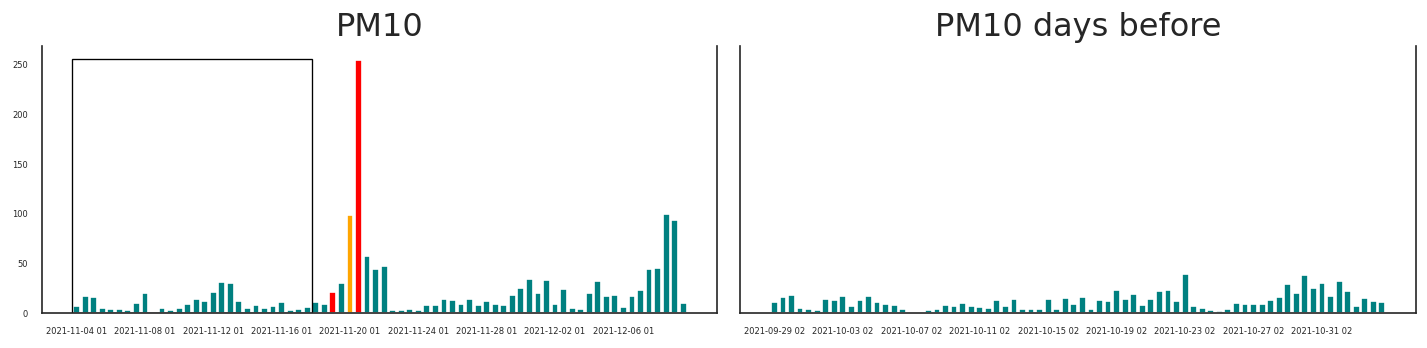

In [ ]:
anomalies_PM10_l= show_data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_thresh[(data_thresh['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

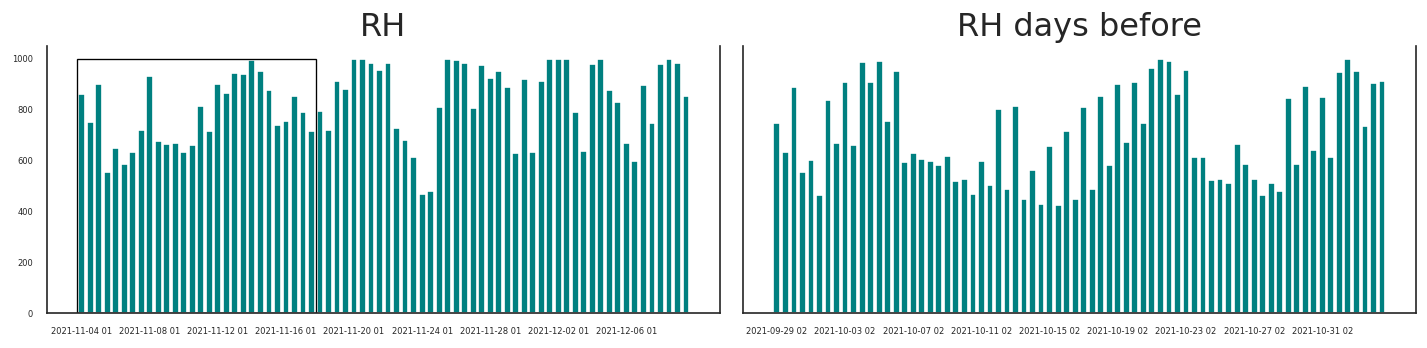

In [ ]:
anomalies_RH_l= show_data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_thresh[(data_thresh['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

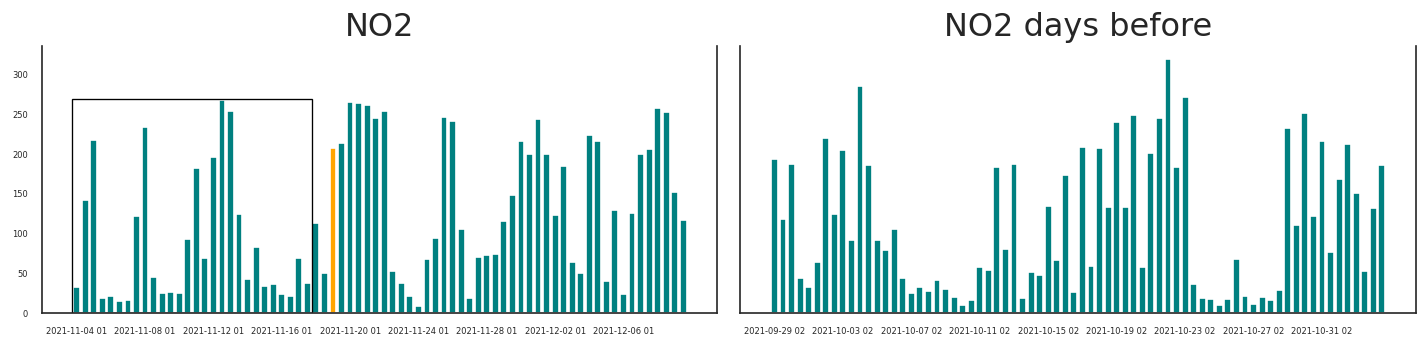

In [ ]:
anomalies_NO2_l= show_data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_thresh[(data_thresh['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

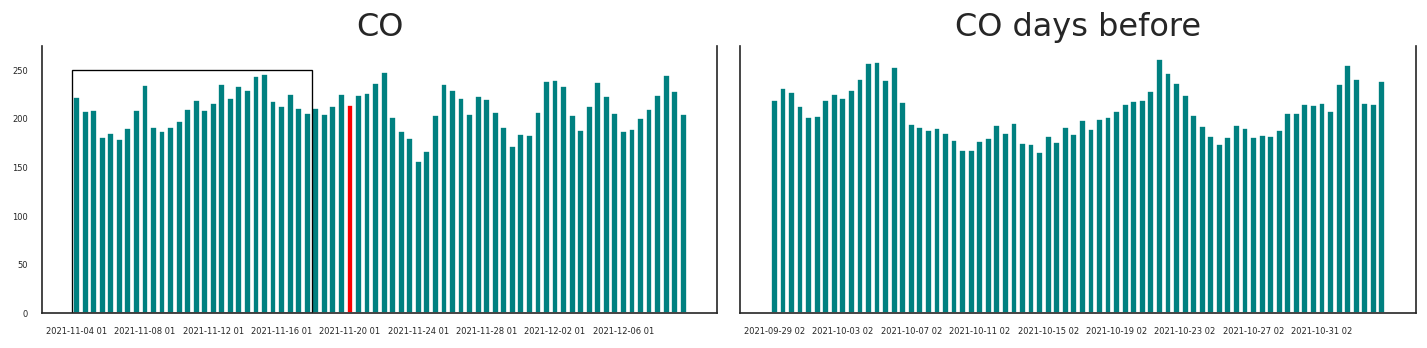

In [ ]:
anomalies_CO_l= show_data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_thresh[(data_thresh['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

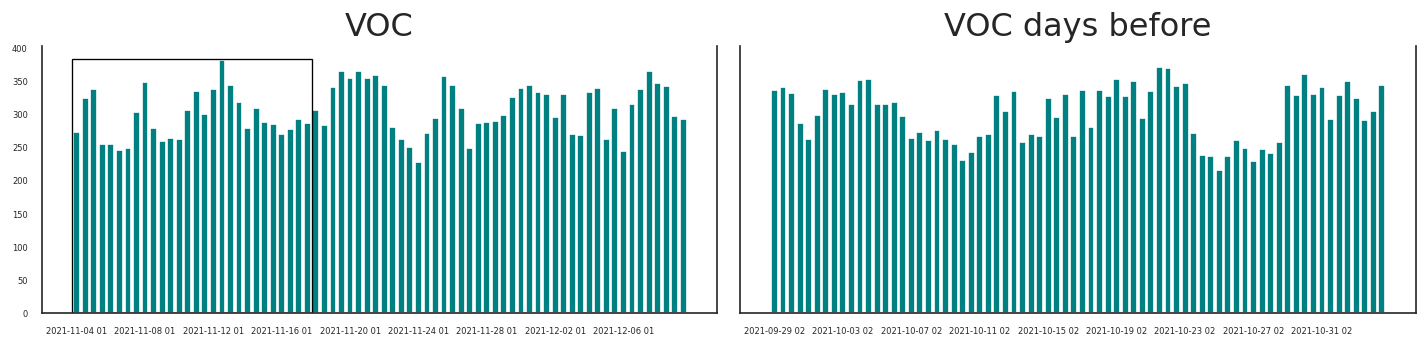

In [ ]:
anomalies_VOC_l= show_data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_thresh[(data_thresh['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Forecast all

Splitting the series into train and testing data (to_predict= how many values are going to be predicted, forecast_interval= how often the forecast will happen)

to_predict must be a multiple of forecast_interval

In [ ]:
to_predict=36
forecast_interval = 2
df_train, df_test = df_copy[0:-to_predict].copy(), df_copy[-to_predict:].copy()
df_train_inputs=df_copy.copy()

# Check size
print(df_train.shape)  
print(df_test.shape)  

(291, 10)
(36, 10)


Check stationarity with all values and only with the starting values

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_end = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
display(adf_test_results_end)


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in ['T', 'Temp. int.', 'NO2', 'PM2.5', 'RH']:
    df_train[col] = differencing(df_train, col, 1)
#anche gli input devono essere post differencing se train viene differenziato e usato nel modello
for col in ['T', 'Temp. int.', 'NO2', 'PM2.5', 'RH']:
    df_train_inputs[col] = differencing(df_train_inputs, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=15
model_lag = VAR(df_train.astype(float))
lag_results_for = model_lag.select_order(max_lag)
selected_lag_for = lag_results_for.aic
print(selected_lag_for)
df_inputs=df_train_inputs[-to_predict-selected_lag_for:-forecast_interval].copy()


6


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
res_fc=pd.DataFrame(index=df_copy.index[-to_predict:], columns=df_copy.columns)
how_many_times=to_predict/forecast_interval
allvalues=[]
model=VAR(df_train.astype(float))
model_fitted = model.fit(selected_lag_for)
var_summaryfor=str(model_fitted.summary())
print(var_summaryfor[0:624])
for i in range(int(how_many_times)):
  if(i==how_many_times-1):
    forecast_input = df_inputs.iloc[-selected_lag_for:].values
  else:
    forecast_input = df_inputs.iloc[(i)*forecast_interval:(i)*forecast_interval+selected_lag_for].values
  fc = model_fitted.forecast(y=forecast_input, steps=forecast_interval)
  if(i==how_many_times-1):
    temp = pd.DataFrame(fc, index=df_copy.index[-forecast_interval:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval-1:], columns=['T','Temp. int.'])
  else:
    temp = pd.DataFrame(fc, index=df_copy.index[-to_predict+i*forecast_interval:-to_predict+(i+1)*forecast_interval], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict+i*forecast_interval-1:-to_predict+(i+1)*forecast_interval], columns=['T','Temp. int.'])
  for col in ['T', 'Temp. int.', 'NO2', 'PM2.5', 'RH']:
    x, x_diff = df_copy[col].iloc[-to_predict+i*forecast_interval-1:-to_predict+i*forecast_interval], temp[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval:]
  for col in ['T', 'Temp. int.', 'NO2', 'PM2.5', 'RH']:
    temp[col]=diff[col]
  res_fc.iloc[i*forecast_interval:(i+1)*forecast_interval]=temp
display(res_fc)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:43:57
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    48.7980
Nobs:                     285.000    HQIC:                   44.1142
Log likelihood:          -9273.68    FPE:                6.71029e+17
AIC:                      40.9804    Det(Omega_mle):     9.64782e+16
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-11-22 01,432.932,48.1048,485.678,20.5425,8.16032,73.6094,1204.43,282.36,243.787,332.768
2021-11-22 13,515.488,36.8759,470.212,22.9853,9.51673,48.8718,1410.29,321.155,272.172,352.052
2021-11-23 01,209.717,-5.80831,399.005,26.7618,14.7424,-9.88417,804.755,46.2754,231.235,320.89
2021-11-23 13,220.03,-1.67946,443.057,25.0257,12.7942,11.2326,1038.2,175.042,247.264,350.674
2021-11-24 01,39.2089,-5.36812,415.158,23.7077,12.3522,-27.2446,604.919,13.5052,180.101,232.054
2021-11-24 13,60.0619,-6.37139,405.164,24.7105,13.2733,-13.6562,520.685,-11.7212,178.839,244.318
2021-11-25 01,141.376,7.56587,427.802,20.3526,8.76402,9.51474,594.009,69.9374,172.895,264.18
2021-11-25 13,168.511,8.33563,429.572,21.405,9.77065,8.82243,626.6,75.0973,179.446,270.614
2021-11-26 01,337.673,13.7228,444.855,22.7921,11.0327,23.0867,947.608,195.765,227.078,325.976


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval==0):
    for_index.append(fc_index[i])

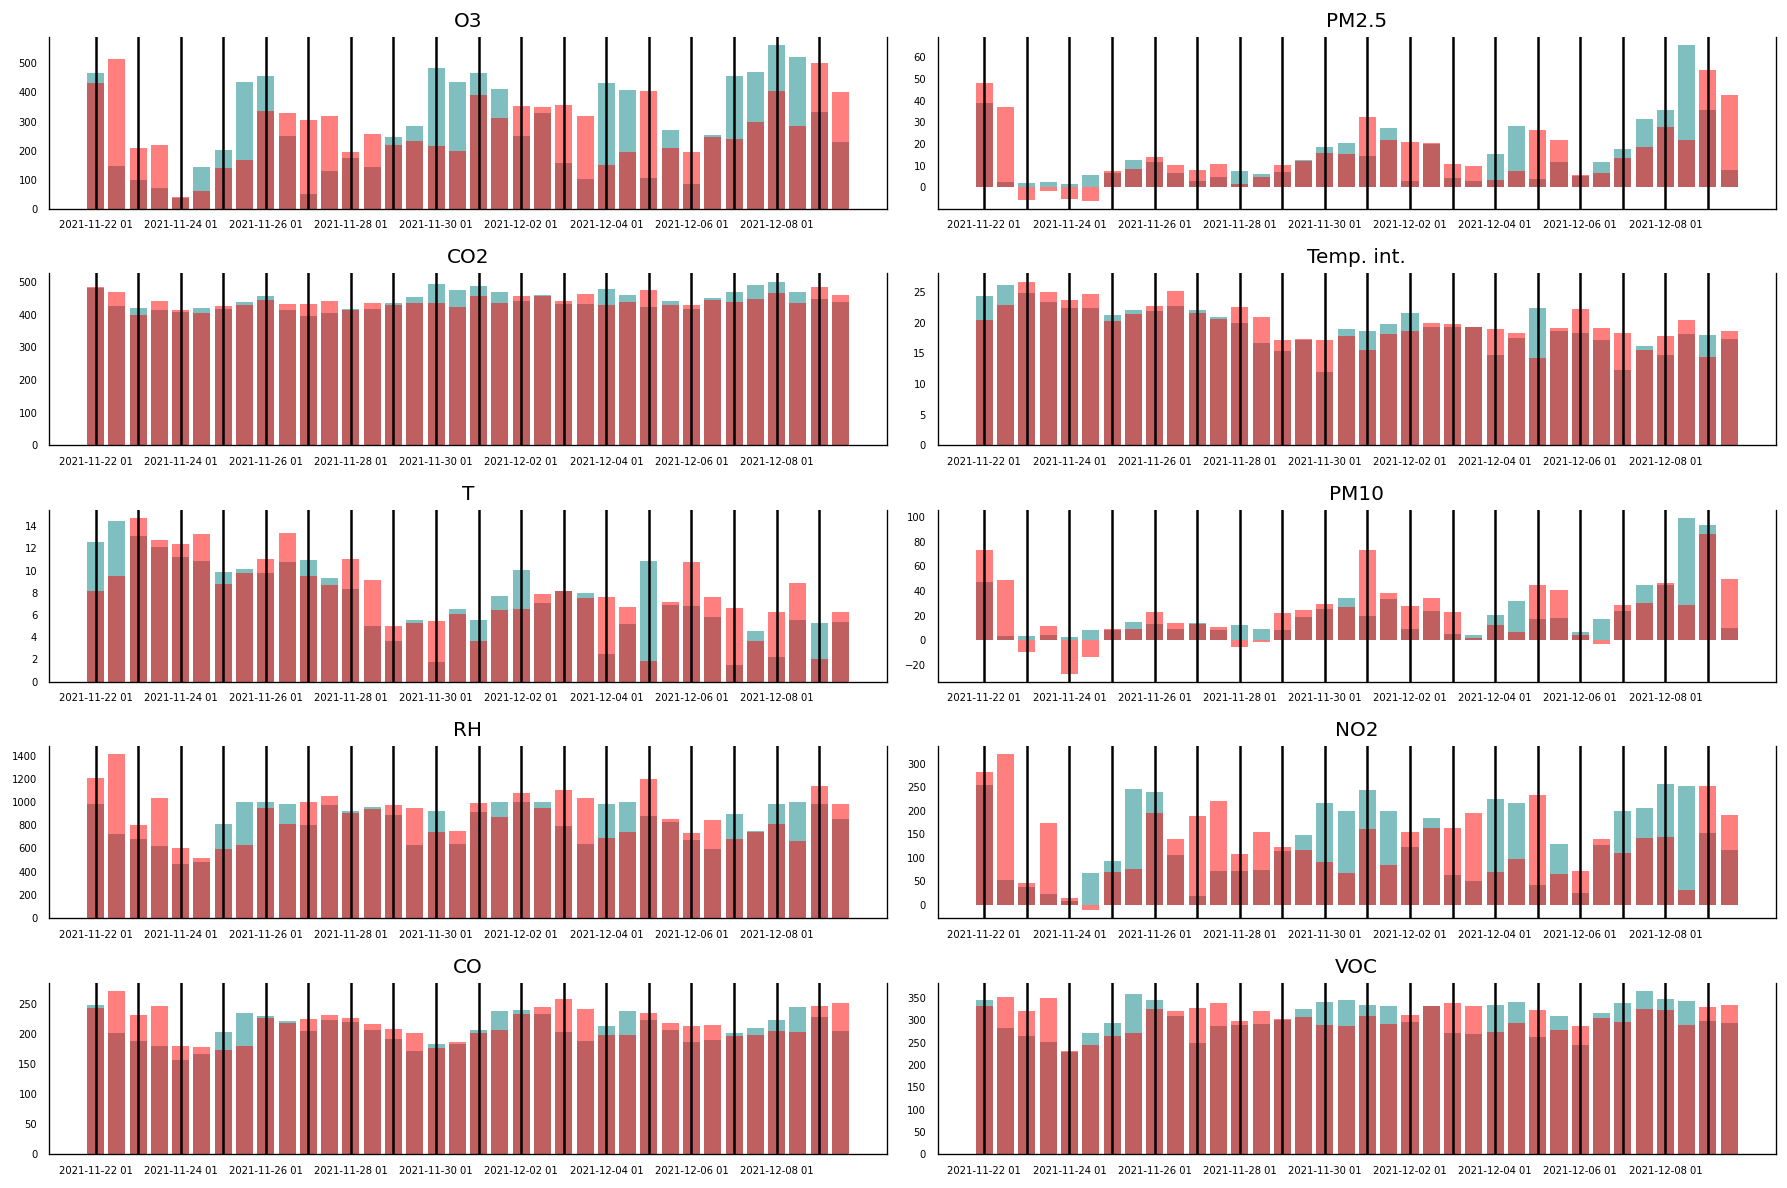

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if(len(df_train.columns)==10):
  num_row=5
else:
  num_row=6
x_ticks = np.arange(0, to_predict, 4)
# Plot
fig, axes = plt.subplots(nrows=num_row, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  if(i<len(df_train.columns)):
    data_for = df_test[df_test.columns[i]]
    data_res_fc=res_fc[res_fc.columns[i]]
    ax.bar(data_for.index, data_for, alpha=0.5,color='teal', linewidth=1)
    ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
    for j in range(len(for_index)):
      ax.axvline(for_index[j]	, color='black')
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.set_xticks(x_ticks)

plt.tight_layout();

Forecast accuracy:

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_test[col])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.8187
me     :  -2.8098
mae    :  145.8776
mpe    :  0.4499
rmse   :  173.1137
minmax :  0.4025
Forecast Accuracy of: PM2.5
mape   :  1.6489
me     :  1.0443
mae    :  10.0963
mpe    :  0.6386
rmse   :  14.3631
minmax :  0.7442
Forecast Accuracy of: CO2
mape   :  0.053
me     :  -3.2581
mae    :  23.8094
mpe    :  -0.0044
rmse   :  28.4154
minmax :  0.0513
Forecast Accuracy of: Temp. int.
mape   :  0.1243
me     :  0.5094
mae    :  2.2291
mpe    :  0.0436
rmse   :  2.8644
minmax :  0.1083
Forecast Accuracy of: T
mape   :  0.4938
me     :  0.4103
mae    :  2.2909
mpe    :  0.2872
rmse   :  2.9795
minmax :  0.2698
Forecast Accuracy of: PM10
mape   :  1.6559
me     :  1.7453
mae    :  16.1974
mpe    :  0.3008
rmse   :  22.5337
minmax :  0.9232
Forecast Accuracy of: RH
mape   :  0.2353
me     :  47.6601
mae    :  185.8119
mpe    :  0.0911
rmse   :  233.9298
minmax :  0.1866
Forecast Accuracy of: NO2
mape   :  1.3187
me     :  -0.2596
mae    :  91.7377
mp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Diving the wind in 3 different categories and using them to create 3 different forecasts

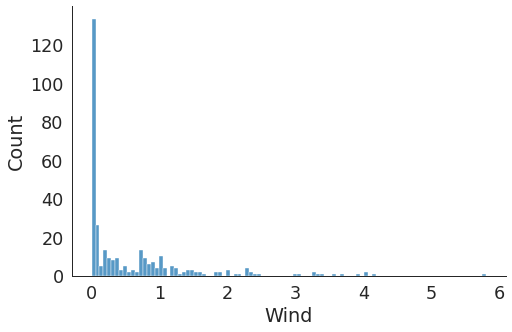

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

df_c=df_copy.copy()
df_train_inputs_w=df_copy.copy()

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_c, x='Wind', kind="hist", bins = 100, aspect = 1.5)

The wind values are diveded in categories: no wind, weak and strong wind.
Weak wind values are between 0 and threshold_wind, strong wind values are greater than threshold_wind

In [ ]:
threshold_wind=0.8

Count how many values would go in each category to find a good threshold

In [ ]:
cnt_w=0
cnt_s=0
cnt_n=0
for i in range(len(df_c)):
  if df_c['Wind'].iloc[i]==0:
    cnt_n+=1
  elif df_c['Wind'].iloc[i]<threshold_wind:
    cnt_w+=1
  else:
    cnt_s+=1
print(cnt_n)
print(cnt_w)
print(cnt_s)

127
104
93


Create 3 tables (1 for each type of wind)

In [ ]:
df_c_n=df_c[(df_c['Wind'] ==0)]
df_c_temp=df_c[(df_c['Wind'] > 0 )]
df_c_w=df_c_temp[(df_c_temp['Wind'] < threshold_wind)]
df_c_s=df_c[(df_c['Wind'] >= threshold_wind)]
display(df_c_n)
display(df_c_w)
display(df_c_s)

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-07-07 02,414.192308,1.217949,425.307692,37.586944,24.397650,3.666667,557.262821,333.668803,228.724359,379.717949,0
2021-07-10 02,317.004329,1.411255,419.051948,34.104502,21.007143,4.504329,558.857143,262.974026,216.822511,344.439394,0
2021-07-13 02,417.707094,3.391304,437.601831,36.628673,23.066590,8.288330,637.437071,365.551487,239.235698,376.627002,0
2021-07-17 02,342.054348,2.097826,425.619565,34.348587,20.940217,4.765217,722.278261,288.126087,228.641304,329.143478,0
2021-07-21 02,412.237473,4.516340,430.671024,37.094793,24.306318,9.265795,619.542484,274.080610,236.093682,364.522876,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 13,348.158898,4.213983,428.569915,29.028581,16.557627,11.578390,911.851695,185.966102,238.754237,345.040254,0
2021-11-04 01,87.539615,1.370450,408.847966,24.892248,13.585225,7.394004,862.126338,32.858672,222.635974,274.520343,0
2021-11-04 13,269.695100,6.638838,445.457350,24.955935,12.988566,17.419238,751.508167,142.727768,207.791289,325.457350,0
2021-11-05 01,404.222698,7.730193,467.507495,22.694690,10.312634,15.944325,901.832976,217.199143,209.259101,339.402570,0


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 02,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481,0.45
2021-07-01 14,417.137313,1.056716,409.904478,39.744209,26.115224,7.200000,454.483582,228.880597,207.528358,337.134328,0.6
2021-07-02 02,349.083871,1.969892,422.098925,34.700559,21.245591,8.215054,674.969892,238.877419,226.440860,333.494624,0.7
2021-07-03 02,379.778261,3.300000,424.069565,35.492370,22.074348,11.047826,723.286957,266.280435,236.469565,344.389130,0.5
2021-07-03 14,460.752711,1.555315,405.748373,43.055228,29.177007,5.173536,466.485900,222.414317,233.915401,372.776573,0.4
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-21 01,511.727079,44.381663,494.901919,22.974670,10.245842,57.157783,986.127932,261.526652,226.776119,355.211087,0.6
2021-11-21 13,466.183932,37.482030,474.949260,26.242727,13.590909,44.594080,954.928118,244.638478,236.830867,360.883721,0.6
2021-11-22 01,466.686567,38.976546,480.859275,24.354925,12.542644,47.699360,983.434968,254.115139,248.609808,345.068230,0.65
2021-12-01 01,467.793926,14.242950,487.149675,18.640868,5.533839,20.117137,913.720174,243.832972,206.941432,334.655098,0.5


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 14,485.677582,1.229219,408.007557,44.385567,30.052645,6.357683,441.720403,251.073048,226.254408,389.267003,2.1
2021-06-30 02,403.322440,1.917211,408.718954,40.068039,25.106100,9.461874,562.250545,268.991285,223.769063,356.978214,1.85
2021-06-30 14,355.258373,1.700957,405.818182,40.966938,26.467464,9.514354,408.889952,194.583732,206.466507,352.296651,1.85
2021-07-01 02,374.174312,2.975535,420.651376,36.713639,21.714679,12.700306,658.027523,309.171254,226.581040,352.969419,1
2021-07-02 14,458.783843,2.120087,408.377729,42.390000,28.552838,10.637555,484.150655,222.185590,233.960699,368.294760,1.25
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 13,471.201699,31.405520,490.388535,16.172718,4.527176,44.700637,746.286624,205.861996,210.118896,366.076433,0.8
2021-12-08 01,562.745182,35.755889,501.655246,14.800535,2.230835,45.019272,981.447537,257.460385,224.274090,348.239829,0.8
2021-12-08 13,520.709130,65.781316,469.065817,18.256051,5.544798,99.751592,999.000000,253.044586,245.318471,343.836518,0.85
2021-12-09 01,334.065957,35.642553,447.497872,18.029447,5.303617,94.046809,982.810638,152.165957,228.582979,298.789362,1


Create 3 different forecast models and use them

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_n= {
    col: test_stationarity(df_c_n, col)
    for col in df_c_n.columns
}
display(adf_test_results_n)    

adf_test_results_w = {
    col: test_stationarity(df_c_w, col)
    for col in df_c_w.columns
}
display(adf_test_results_w)

adf_test_results_s = {
    col: test_stationarity(df_c_s, col)
    for col in df_c_s.columns
}
display(adf_test_results_s)  

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in double_scalars
  return self.params / self.bse
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary',
 'Wind': 'Non-Stationary'}

{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Non-Stationary',
 'Wind': 'Non-Stationary'}

{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary',
 'Wind': 'Non-Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
#no wind
for col in df_c.columns:
    df_c_n[col] = differencing(df_c_n, col, 1)
#weak wind
for col in df_c.columns:
    df_c_w[col] = differencing(df_c_w, col, 1)
#strong wind
for col in df_c.columns:
    df_c_s[col] = differencing(df_c_s, col, 1)
#inputs
for col in df_c.columns:
    df_train_inputs_w[col] = differencing(df_train_inputs_w, col, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Find the best lag and create the models

In [ ]:
df_c_n=df_c_n.drop('Wind', axis=1)

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=3

model_n = VAR(df_c_n.astype(float))
lag_results_n = model_n.select_order(max_lag)
selected_lag_n = lag_results_n.aic
print('selected lag for the null: '+str(selected_lag_n))
model_fitted_n = model_n.fit(selected_lag_n)
var_summaryn=str(model_fitted_n.summary())
print(var_summaryn[0:624])

model_w = VAR(df_c_w.astype(float))
lag_results_w = model_w.select_order(max_lag)
selected_lag_w = lag_results_w.aic
print('selected lag for the weak: '+str(selected_lag_w))
model_fitted_w = model_w.fit(selected_lag_w)
var_summaryw=str(model_fitted_w.summary())
print(var_summaryw[0:624])

model_s = VAR(df_c_s.astype(float))
lag_results_s = model_s.select_order(max_lag)
selected_lag_s = lag_results_s.aic
selected_lag_s=3
print('selected lag for the strong: '+str(selected_lag_s))
model_fitted_s = model_s.fit(selected_lag_s)
var_summarys=str(model_fitted_s.summary())
print(var_summarys[0:624])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


selected lag for the null: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:47:16
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    44.7028
Nobs:                     126.000    HQIC:                   43.2326
Log likelihood:          -4338.14    FPE:                2.19153e+18
AIC:                      42.2267    Det(Omega_mle):     9.48960e+17
--------------------------------------------------------------------

selected lag for the weak: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:47:16
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    49.1672
Nobs:                     101.000    HQ

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Predicting "to_predict_w" values using "forecast_interval_w" in "times" steps.
Finding the median of every "step" to choose the correct model and forecast all values
to_predict_w should always be a multiple of forecast_interval_w

In [ ]:
to_predict_w=36
forecast_interval_w = 2
times= int(to_predict_w/forecast_interval_w)
res_fc=pd.DataFrame(index=df_copy.index[-to_predict_w:], columns=df_copy.columns)
allvalues=[]
df_inputs_no=df_train_inputs_w[-to_predict_w-selected_lag_n:-forecast_interval_w].copy()
df_inputs_weak=df_train_inputs_w[-to_predict_w-selected_lag_w:-forecast_interval_w].copy()
df_inputs_strong=df_train_inputs_w[-to_predict_w-selected_lag_s:-forecast_interval_w].copy()
for i in range(times):
  if(-to_predict_w+(i+1)*forecast_interval_w==0):
    temp=df_c.iloc[-forecast_interval_w:]
    forecast_input_no= df_inputs_no.iloc[-selected_lag_n:].values
    forecast_input_weak= df_inputs_weak.iloc[-selected_lag_w:].values
    forecast_input_strong= df_inputs_strong.iloc[-selected_lag_s:].values
  else:
    temp=df_c.iloc[-to_predict_w+i*forecast_interval_w:-to_predict_w+(i+1)*forecast_interval_w]
    forecast_input_no= df_inputs_no.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_n].values
    forecast_input_weak= df_inputs_weak.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_w].values
    forecast_input_strong= df_inputs_strong.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_s].values
  if temp['Wind'].median() <= 0.15:
    print(str(i)+' no wind')
    fc = model_fitted_n.forecast(y=forecast_input_no, steps=forecast_interval_w)
  if temp['Wind'].median() <1 and temp['Wind'].median()>0.15:
    print(str(i)+' weak wind')
    fc = model_fitted_w.forecast(y=forecast_input_weak, steps=forecast_interval_w)
  if temp['Wind'].median()>=1:
    print(str(i)+' strong wind')
    fc = model_fitted_s.forecast(y=forecast_input_strong, steps=forecast_interval_w)
  if(-to_predict_w+(i+1)*forecast_interval_w==0):
    temp_res = pd.DataFrame(fc, index=df_copy.index[-forecast_interval_w:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval_w-1:], columns=df_c.columns)
  else:
    temp_res = pd.DataFrame(fc, index=df_copy.index[-to_predict_w+i*forecast_interval_w:-to_predict_w+(i+1)*forecast_interval_w], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict_w+i*forecast_interval_w-1:-to_predict_w+(i+1)*forecast_interval_w], columns=df_copy.columns)
  for col in df_copy.columns:
    x, x_diff = df_copy[col].iloc[-to_predict_w+i*forecast_interval_w-1:-to_predict_w+i*forecast_interval_w], temp_res[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval_w:]
  for col in df_copy.columns:
    temp_res[col]=diff[col]
  res_fc.iloc[i*forecast_interval_w:(i+1)*forecast_interval_w]=temp_res
display(res_fc)

0 strong wind
1 strong wind
2 strong wind
3 strong wind
4 strong wind
5 strong wind
6 strong wind
7 strong wind
8 weak wind
9 weak wind
10 strong wind
11 strong wind
12 weak wind
13 strong wind
14 strong wind
15 weak wind
16 weak wind
17 strong wind


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-11-22 01,533.959,74.6789,486.976,19.1311,6.24424,189.141,1268.46,290.516,244.912,358.06,-0.162041
2021-11-22 13,494.865,59.8145,462.68,22.6379,9.62343,133.115,1016.49,244.921,227.103,355.223,1.38292
2021-11-23 01,151.599,10.1624,432.549,20.6354,9.43829,-22.6832,749.831,80.8229,202.903,287.919,3.90888
2021-11-23 13,104.216,1.11501,430.376,21.3797,10.537,-39.7921,673.812,35.7977,195.176,263.192,3.6095
2021-11-24 01,156.175,-8.26111,444.418,25.9203,15.2025,-30.9459,491.251,62.4874,180.058,283.821,1.02438
2021-11-24 13,368.875,7.93837,469.873,23.3037,11.9964,-0.132112,688.678,172.374,191.142,328.531,1.27789
2021-11-25 01,161.748,4.17964,422.954,22.262,10.8844,4.58208,607.392,60.4983,177.966,268.92,2.1233
2021-11-25 13,244.46,12.6351,435.302,22.6919,11.04,19.8848,659.49,114.919,185.818,295.912,2.25339
2021-11-26 01,363.097,9.82061,435.137,23.3696,11.4476,15.9853,928.913,171.365,223.768,327.197,1.76365
2021-11-26 13,235.194,6.2134,420.927,21.4581,9.92936,12.3433,866.7,125.875,206.79,293.232,1.76075


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval_w==0):
    for_index.append(fc_index[i])

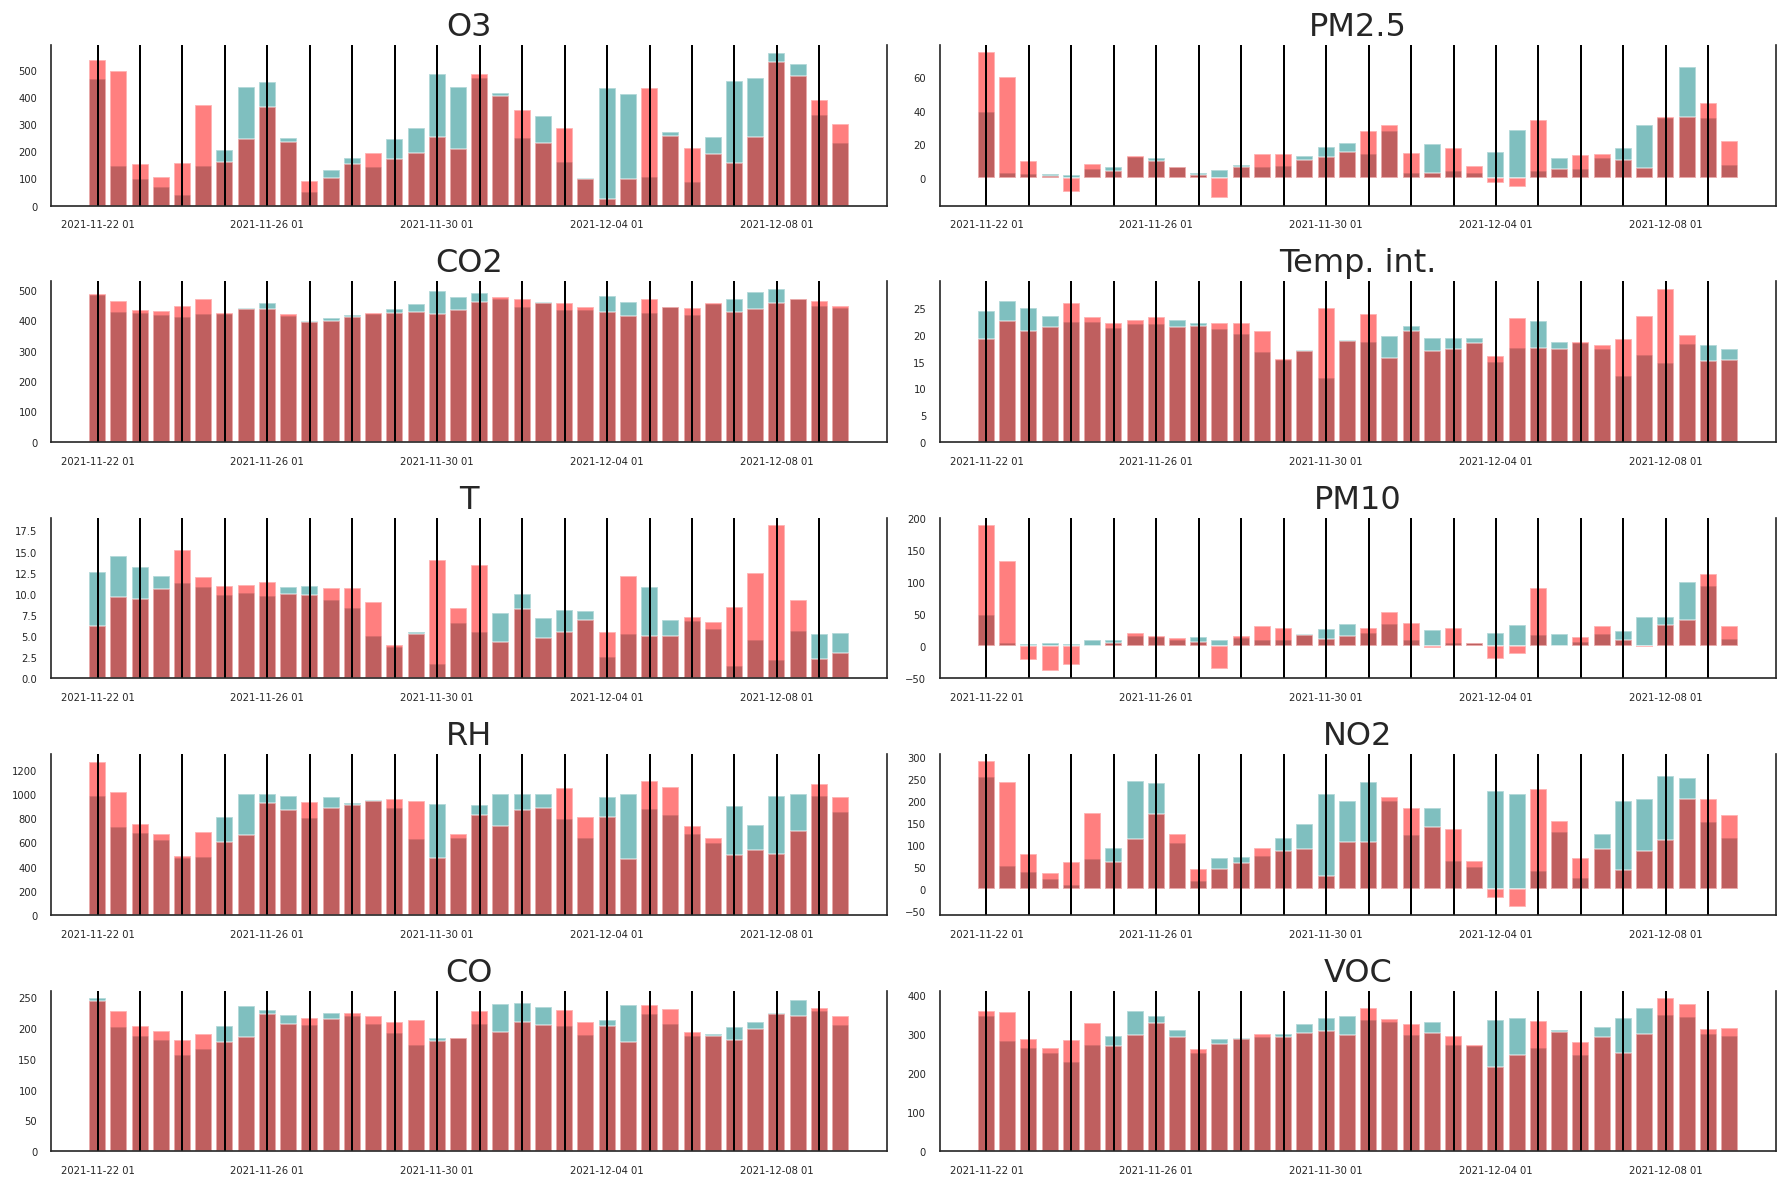

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_ticks = np.arange(0, to_predict_w, 8)
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  data_for_w = df_c[df_c.columns[i]].iloc[-to_predict_w:]
  data_res_fc=res_fc[res_fc.columns[i]]
  ax.bar(data_for_w.index, data_for_w, alpha=0.5,color='teal', linewidth=1)
  ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
  for j in range(len(for_index)):
    ax.axvline(for_index[j]	, color='black')
  # Decorations
  ax.set_title(df_copy.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines["top"].set_alpha(0)
  ax.tick_params(labelsize=6)
  ax.set_xticks(x_ticks)

plt.tight_layout();

Forecast accuracy:

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #mette forecast e actual in 2 colonne parallele (hstack) e trova il minimo/massimo per ogni riga tra le 2 colonne
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_c[col].iloc[-to_predict_w:])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.6167
me     :  -21.3101
mae    :  118.979
mpe    :  0.2545
rmse   :  161.6787
minmax :  0.3499
Forecast Accuracy of: PM2.5
mape   :  1.9509
me     :  1.1948
mae    :  11.5563
mpe    :  0.9275
rmse   :  16.9969
minmax :  0.7593
Forecast Accuracy of: CO2
mape   :  0.0493
me     :  -4.2464
mae    :  22.3858
mpe    :  -0.0068
rmse   :  29.5492
minmax :  0.048
Forecast Accuracy of: Temp. int.
mape   :  0.1782
me     :  0.8723
mae    :  3.0419
mpe    :  0.0774
rmse   :  4.3897
minmax :  0.1338
Forecast Accuracy of: T
mape   :  0.9066
me     :  1.1566
mae    :  3.532
mpe    :  0.6465
rmse   :  4.8805
minmax :  0.3318
Forecast Accuracy of: PM10
mape   :  3.0478
me     :  1.7623
mae    :  27.9817
mpe    :  0.4361
rmse   :  41.8979
minmax :  1.5512
Forecast Accuracy of: RH
mape   :  0.2202
me     :  -35.4206
mae    :  185.8595
mpe    :  -0.0139
rmse   :  230.5089
minmax :  0.1973
Forecast Accuracy of: NO2
mape   :  0.9387
me     :  -22.1602
mae    :  79.3979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
